In [90]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression as LogisticRegression_sklearn
from sklearn.tree import DecisionTreeClassifier as DecisionTreeClassifier_sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from copy import deepcopy
from collections import Counter
from random import choice
from math import inf, log2
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from random import random
import warnings

## Setup Functions for Reading csv file

In [21]:
warnings.filterwarnings('ignore')

def dataSetClassesFrequenciesBarPlot(target):
    freqs = target.value_counts() / len(target)

    std_errors = np.sqrt(freqs*(1-freqs)/len(target))
    expected_frequency = 1/len(np.unique(target))
    freqs.plot(kind='bar',yerr=std_errors*1.96)
    plt.axhline(expected_frequency,color='red',linestyle='--')
    

def get_samples(X):

    attributeNames = []
    
    for elem in X.columns:
        attributeNames.append(elem)

    examples = []

    for row in X.itertuples():
        *attributes, label = row[1:]

        example = dict(zip(attributeNames, attributes))
        example["CLASS"] = label
        examples.append(example)

    return examples

def prepareDataSet(dataSetName):

    dataset_file = dataSetName.lower()

    f_in = open(dataset_file, 'r')
    csv_reader = csv.reader(f_in, delimiter=",")

    row = next(csv_reader)

    attributeNames = row[:-1]

    examples = []
    classes = set()

    for row in csv_reader:
        *attributes, label = row

        if label == "FALSE":
            classes.add(False)
        elif label == "TRUE":
            classes.add(True)

        example = dict(zip(attributeNames, attributes))
        example["CLASS"] = label
        examples.append(example)

    f_in.close()
    return classes, attributeNames, examples

## Data Analysis

In [5]:
data = pd.read_csv("dataset.csv")

categorical_attributes = [("Revenue", 17), ("Weekend", 16), ("VisitorType", 15), ("TrafficType", 14), ("Region", 13), ("Browser", 12), ("OperatingSystems", 11), ("Month", 10)]

classes, attributes, examples = prepareDataSet("dataset.csv")
classes = list(classes)

num_div = 10
ml_dic_div = {}

X = data.loc[:]
y = data.loc[:, ["Revenue"]]

train_count = []
test_count = []

classes_values = {}
classes_values[classes[0]] = {}
classes_values[classes[0]]["train"] = []
classes_values[classes[0]]["test"] = []
classes_values[classes[1]] = {}
classes_values[classes[1]]["train"] = []
classes_values[classes[1]]["test"] = []

for elem in range(num_div):

    if elem == 0:
        for step in range(10, 100, 10):
            X_train, X_test, T_train, T_test = train_test_split(X, y, random_state=10, train_size = step / 100)
            train_count.append(T_train.value_counts())
            test_count.append(T_test.value_counts())

            classes_values[classes[0]]["train"].append(train_count[-1][classes[0]])
            classes_values[classes[0]]["test"].append(test_count[-1][classes[0]])
            classes_values[classes[1]]["train"].append(train_count[-1][classes[1]])
            classes_values[classes[1]]["test"].append(test_count[-1][classes[1]])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size = .8)

    ml_dic_div[elem] = {}
    ml_dic_div[elem]["T"] = {}
    ml_dic_div[elem]["X"] = {}
    ml_dic_div[elem]["X"]["train"] = pd.DataFrame(X_train).loc[:, attributes]
    ml_dic_div[elem]["X"]["train_labels"] = pd.DataFrame(X_train)
    ml_dic_div[elem]["T"]["train"] = y_train
    ml_dic_div[elem]["X"]["test"] = pd.DataFrame(X_test).loc[:, attributes]
    ml_dic_div[elem]["X"]["test_labels"] = pd.DataFrame(X_test)
    ml_dic_div[elem]["T"]["test"] = y_test


print("Number of 'False' values (mean) in Training Set :" + str(round(sum(classes_values[False]["train"]) / len(classes_values[False]["train"]))))

print("Number of 'False' values (mean) in Testing Set :" + str(round(sum(classes_values[False]["test"]) / len(classes_values[False]["test"]))))

print("Number of 'True' values (mean) in Training Set :" + str(round(sum(classes_values[True]["train"]) / len(classes_values[True]["train"]))))

print("Number of 'True' values (mean) in Testing Set :" + str(round(sum(classes_values[True]["test"]) / len(classes_values[True]["test"]))))

rand_test_num = int(random() * 10)

Number of 'False' values (mean) in Training Set :5212
Number of 'False' values (mean) in Testing Set :5210
Number of 'True' values (mean) in Training Set :953
Number of 'True' values (mean) in Testing Set :955


Frequencies for Training Set


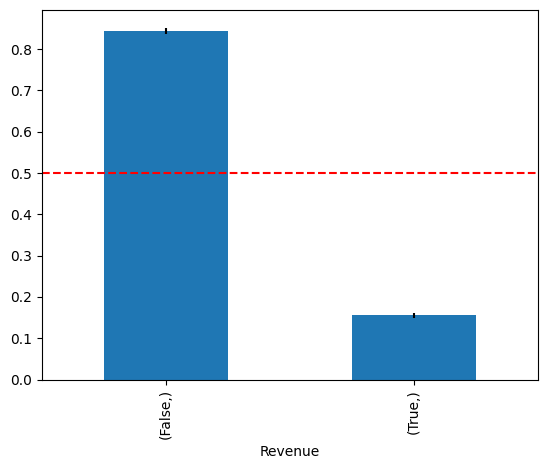

In [280]:
print("Frequencies for Training Set")
dataSetClassesFrequenciesBarPlot(ml_dic_div[rand_test_num]["T"]["train"])

Frequencies for Testing Set


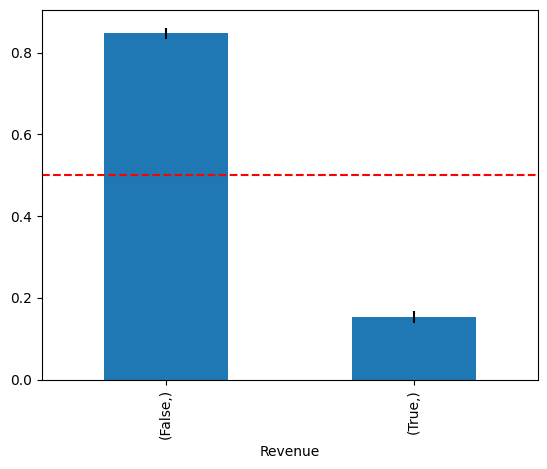

In [281]:
print("Frequencies for Testing Set")
dataSetClassesFrequenciesBarPlot(ml_dic_div[rand_test_num]["T"]["test"])

In [6]:
def count(list, l, r):
    list.sort()

    left_idx = bisect.bisect_left(list, l)

    right_idx = bisect.bisect_right(list, r)

    count = right_idx - left_idx

    return count

attrs = attributes.copy()

for elem in categorical_attributes:
    if elem[0] == "Month" or elem[0] == "VisitorType" or elem[0] == "Weekend":
        attrs.pop(attrs.index(elem[0]))

numerical_attributes = attrs

num_samples_dict_train = {}
num_samples_dict_test = {}

for elem in numerical_attributes:
    num_samples_dict_train[elem] = []
    aux_list = list(ml_dic_div[rand_test_num]["X"]["train"][elem])
    for i_quant in range(0, 100, 10):
        lower_bound = np.percentile(aux_list, i_quant)
        upper_bound = np.percentile(aux_list, i_quant + 10)
        num_samples_dict_train[elem].append(count(aux_list, lower_bound, upper_bound))

for elem in numerical_attributes:
    num_samples_dict_test[elem] = []
    aux_list = list(ml_dic_div[rand_test_num]["X"]["test"][elem])
    for i_quant in range(0, 100, 10):
        lower_bound = np.percentile(aux_list, i_quant)
        upper_bound = np.percentile(aux_list, i_quant + 10)
        num_samples_dict_test[elem].append(count(aux_list, lower_bound, upper_bound))

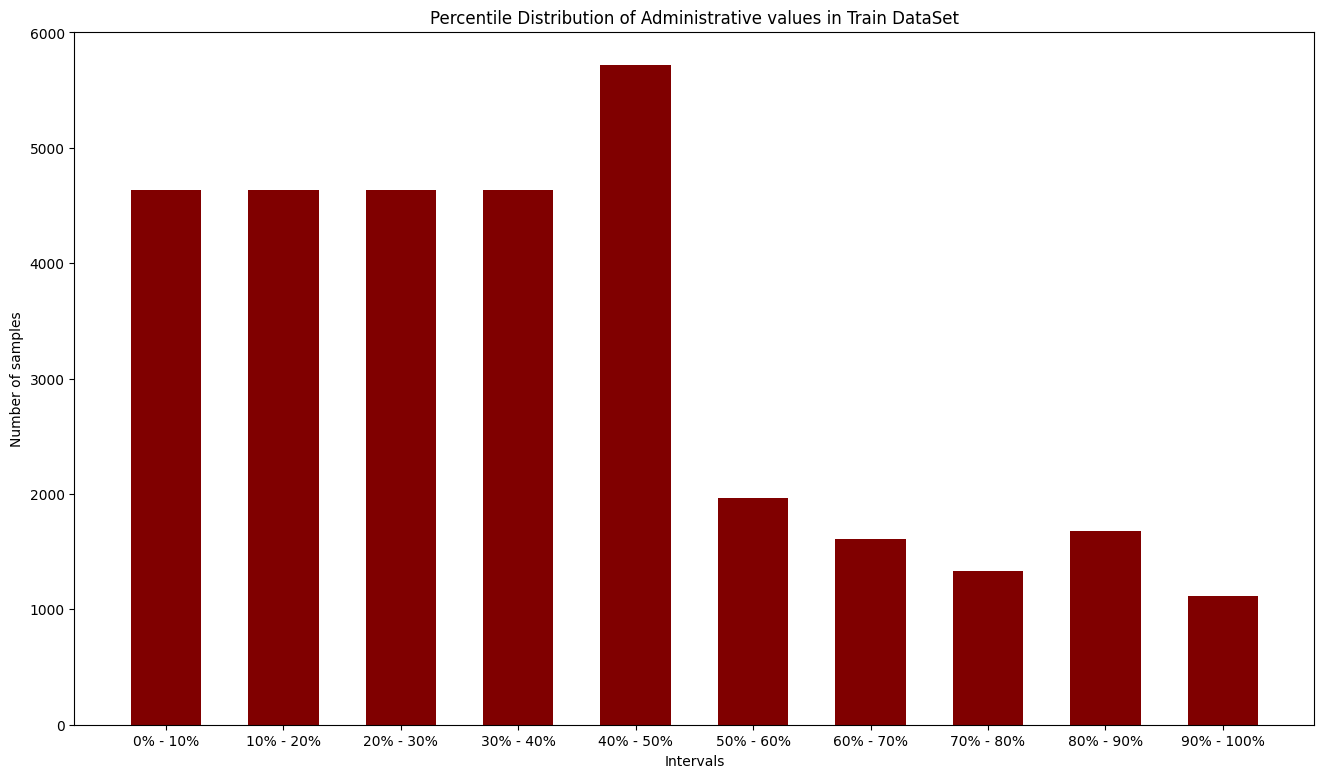

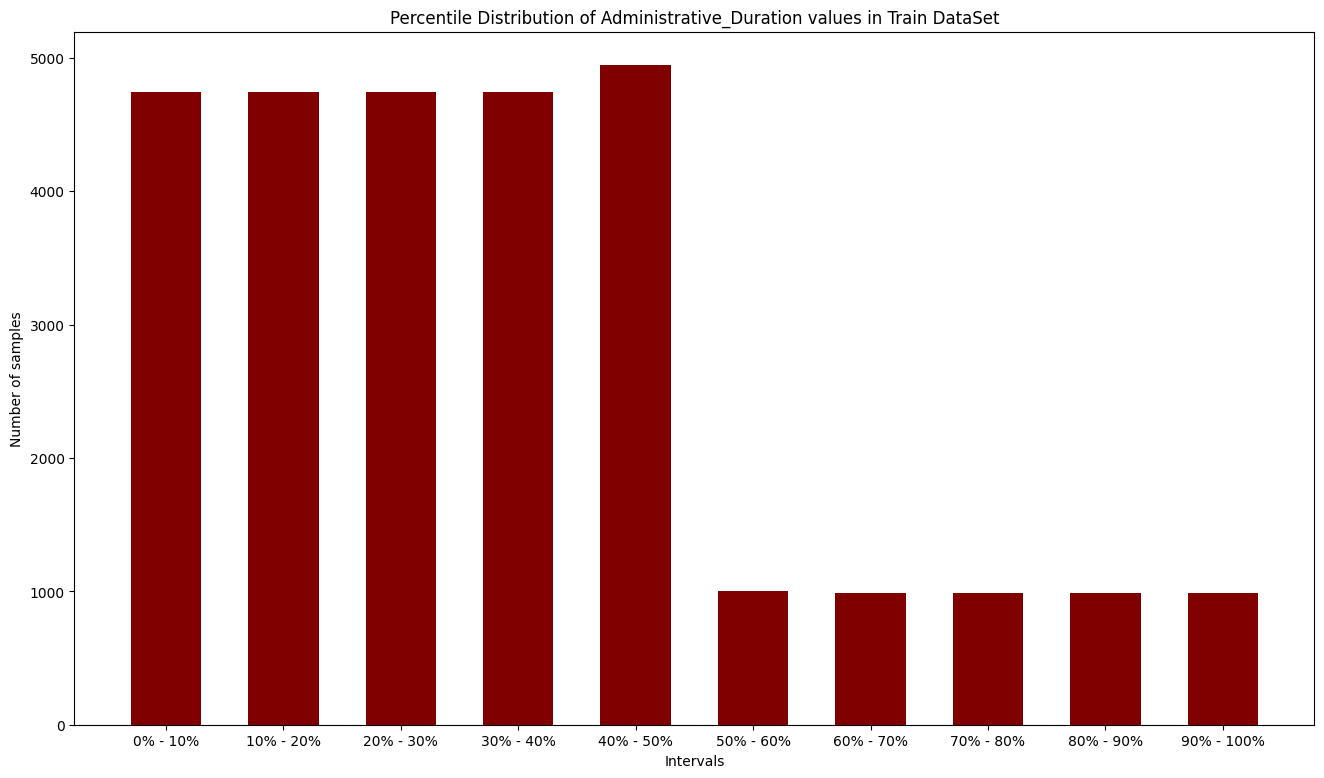

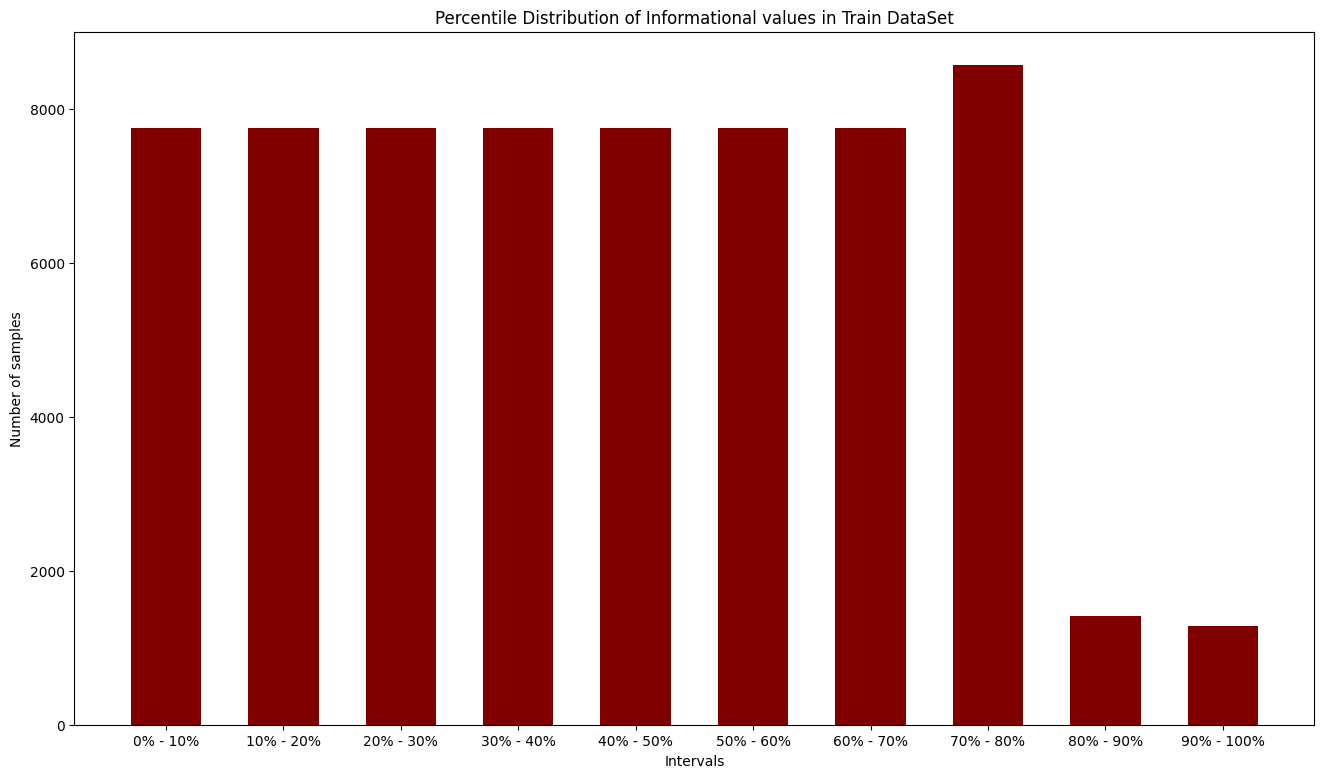

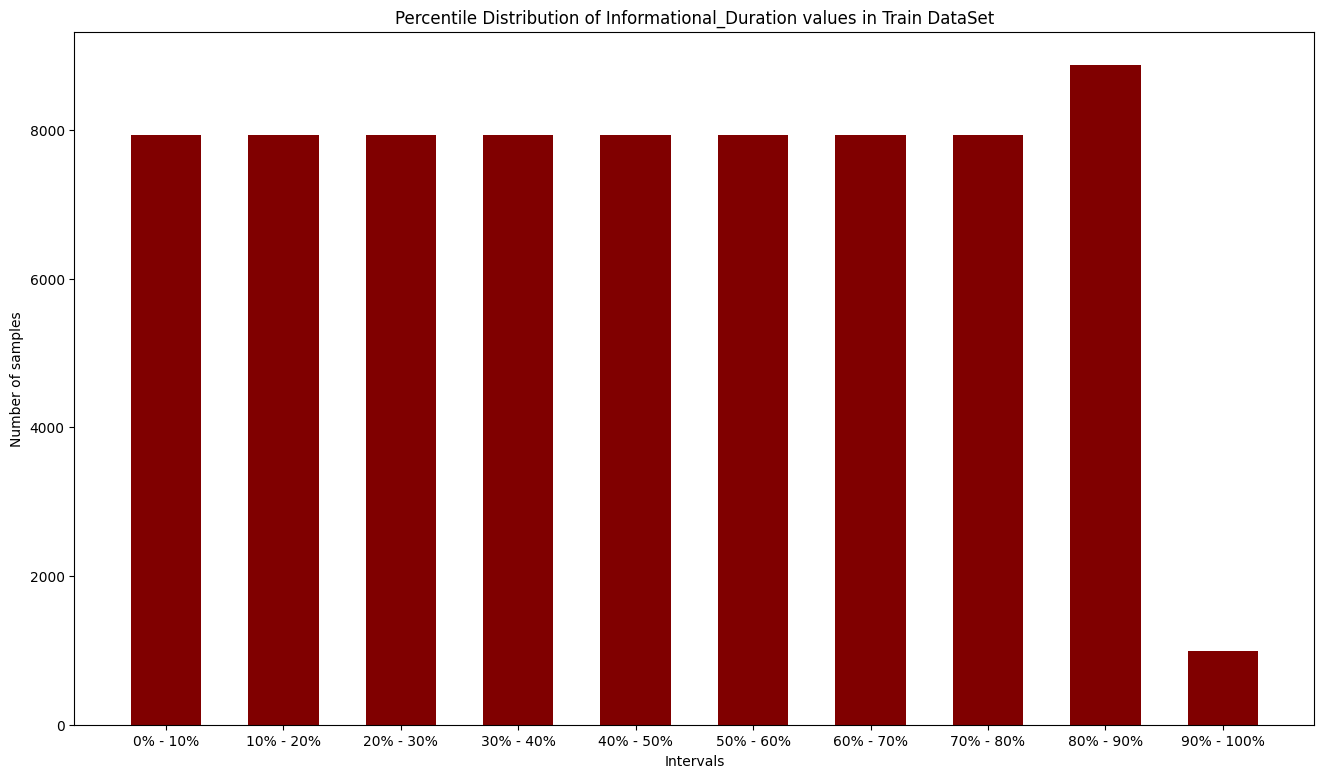

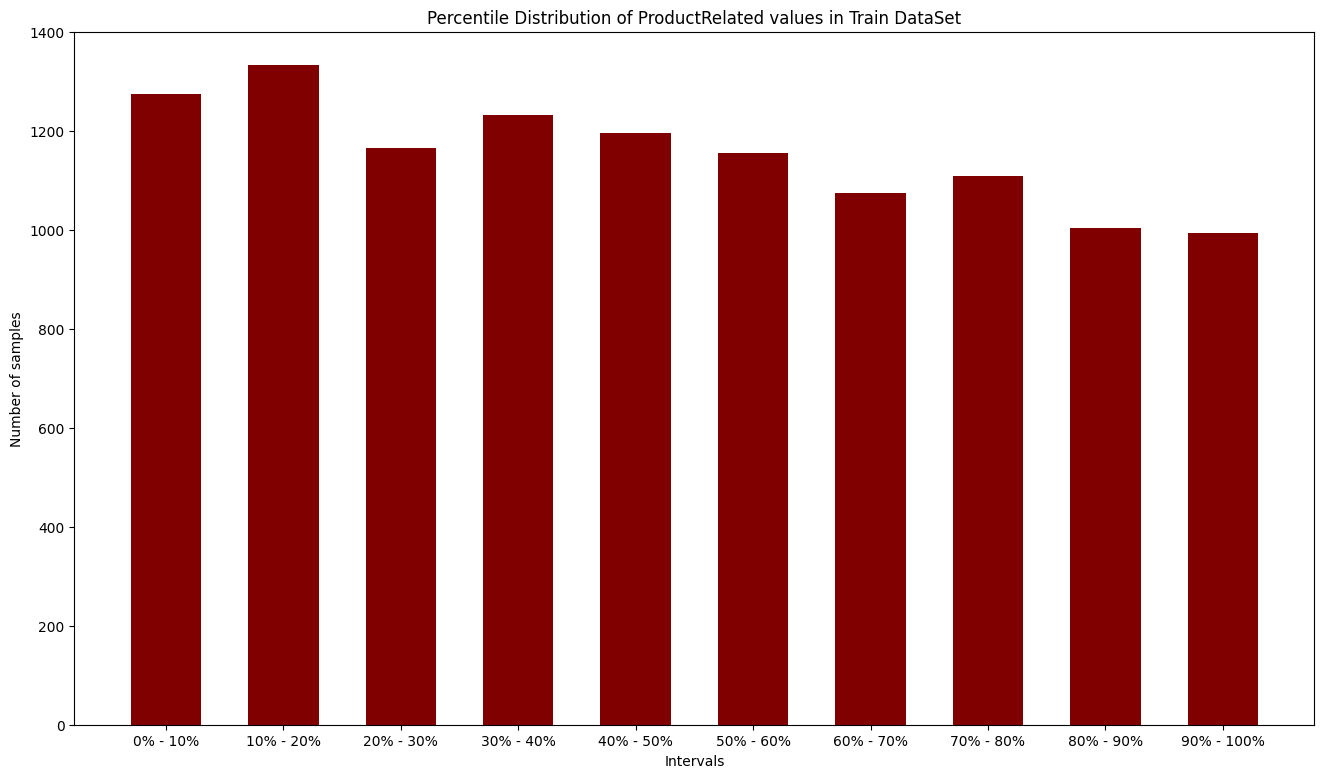

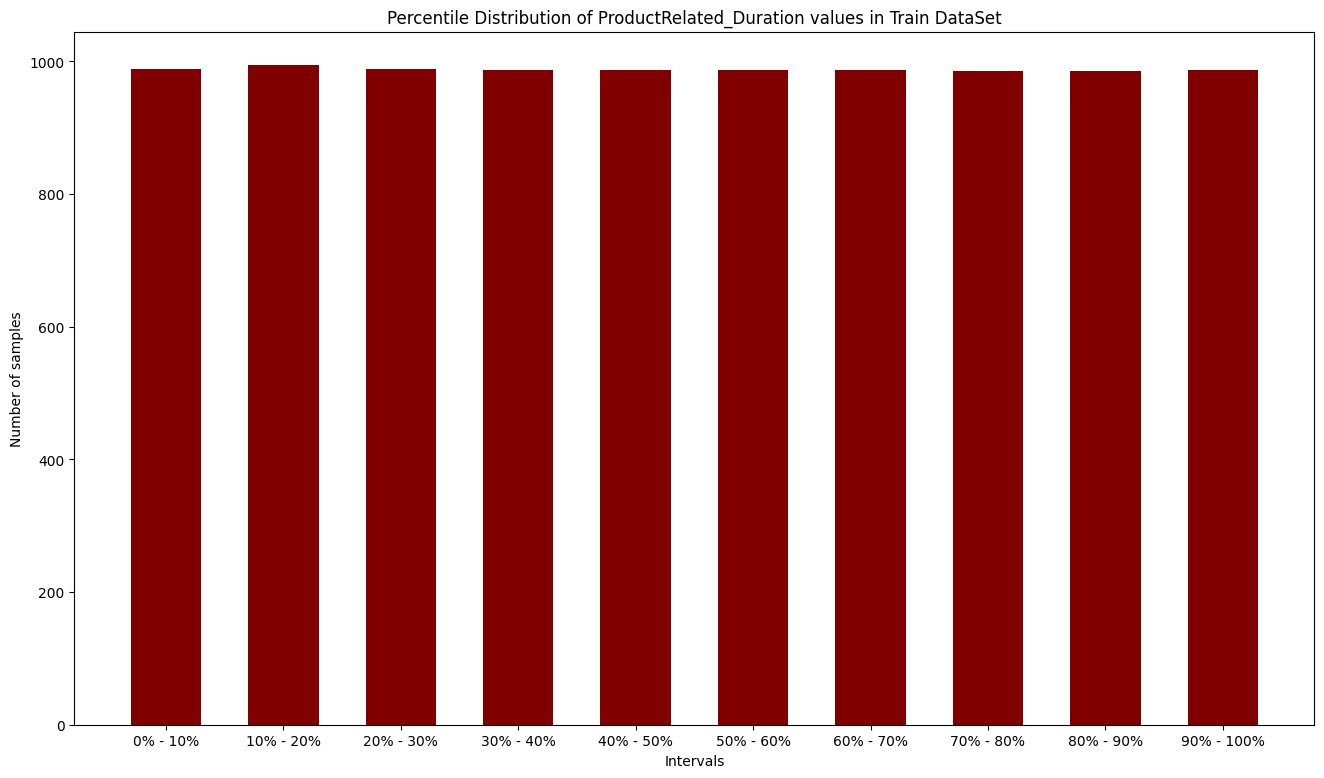

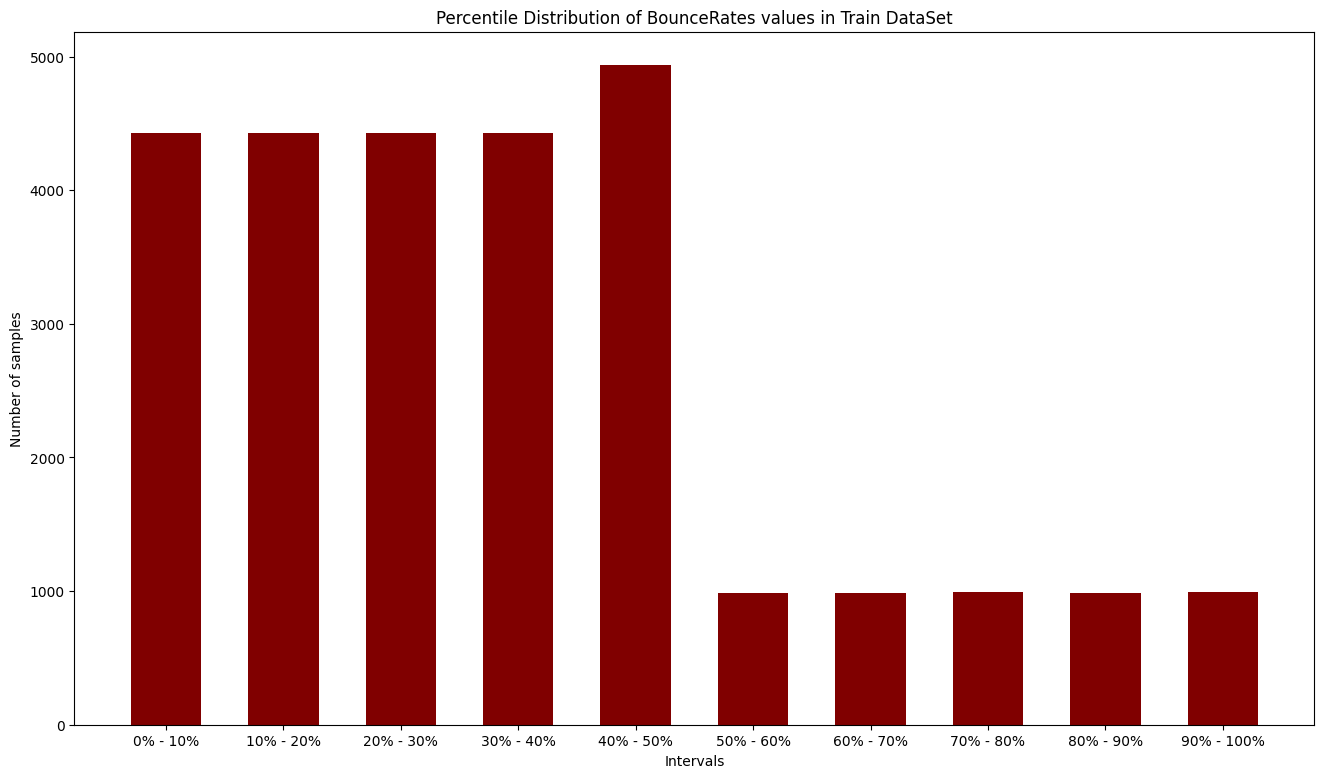

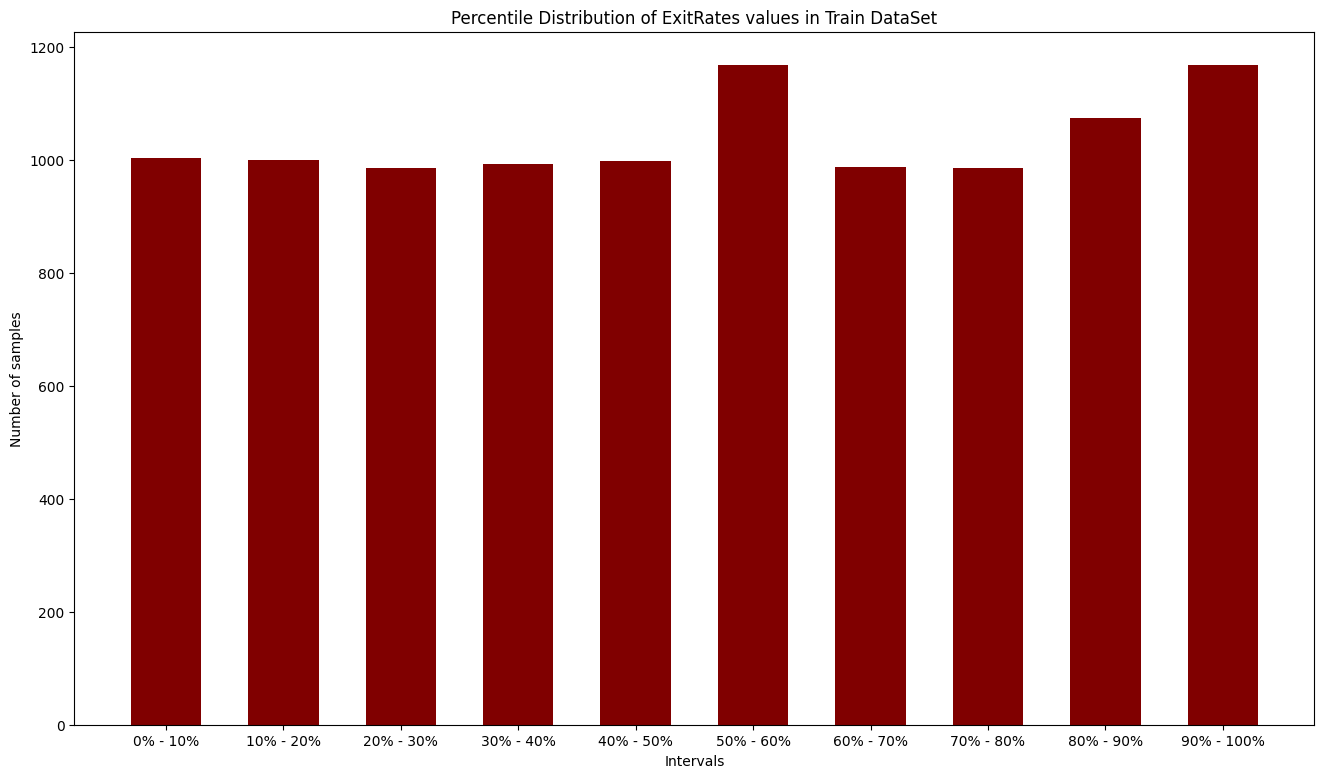

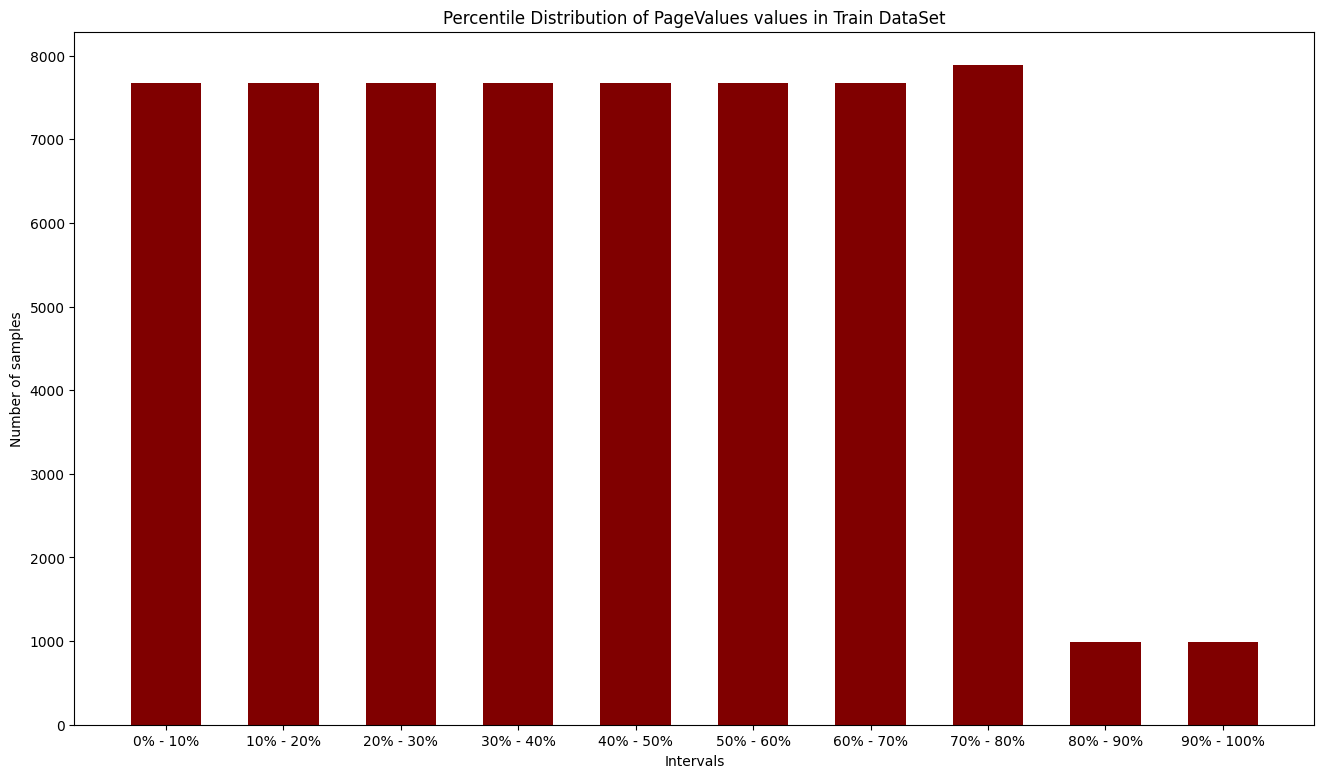

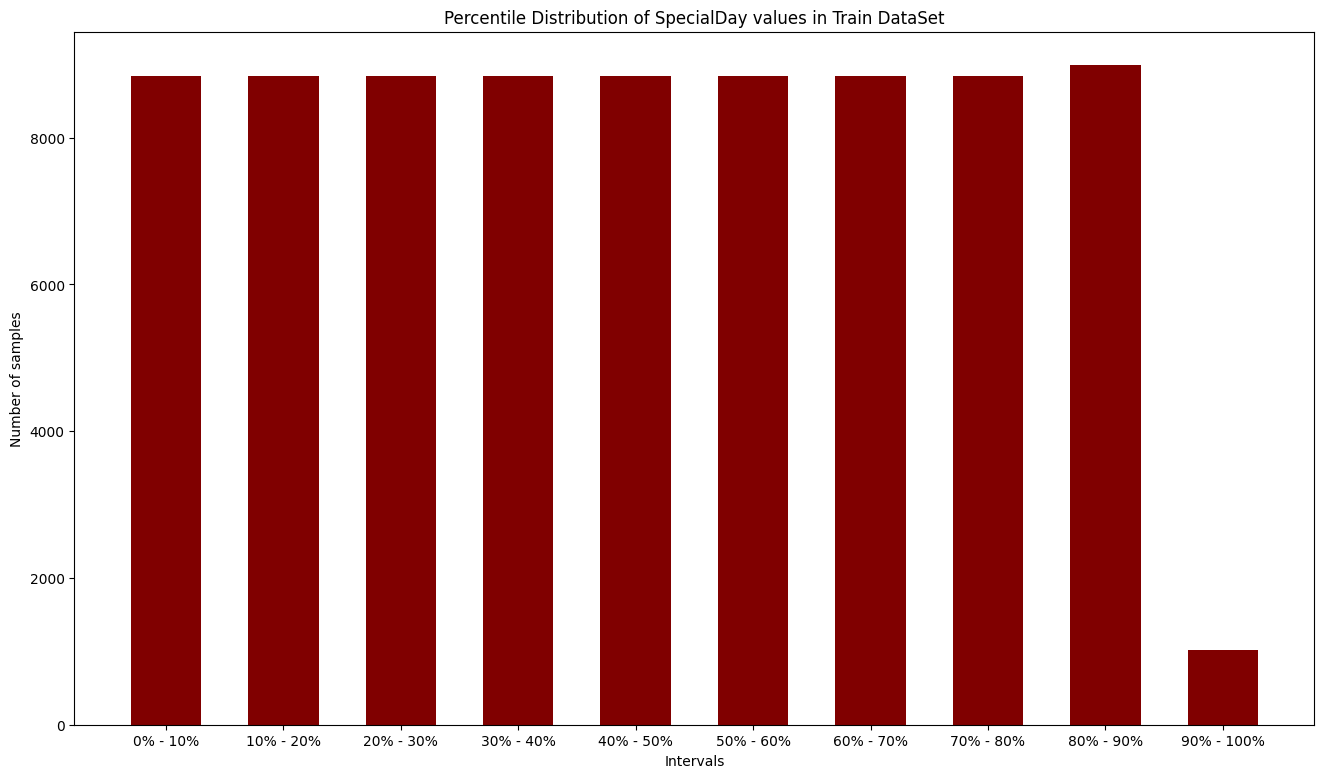

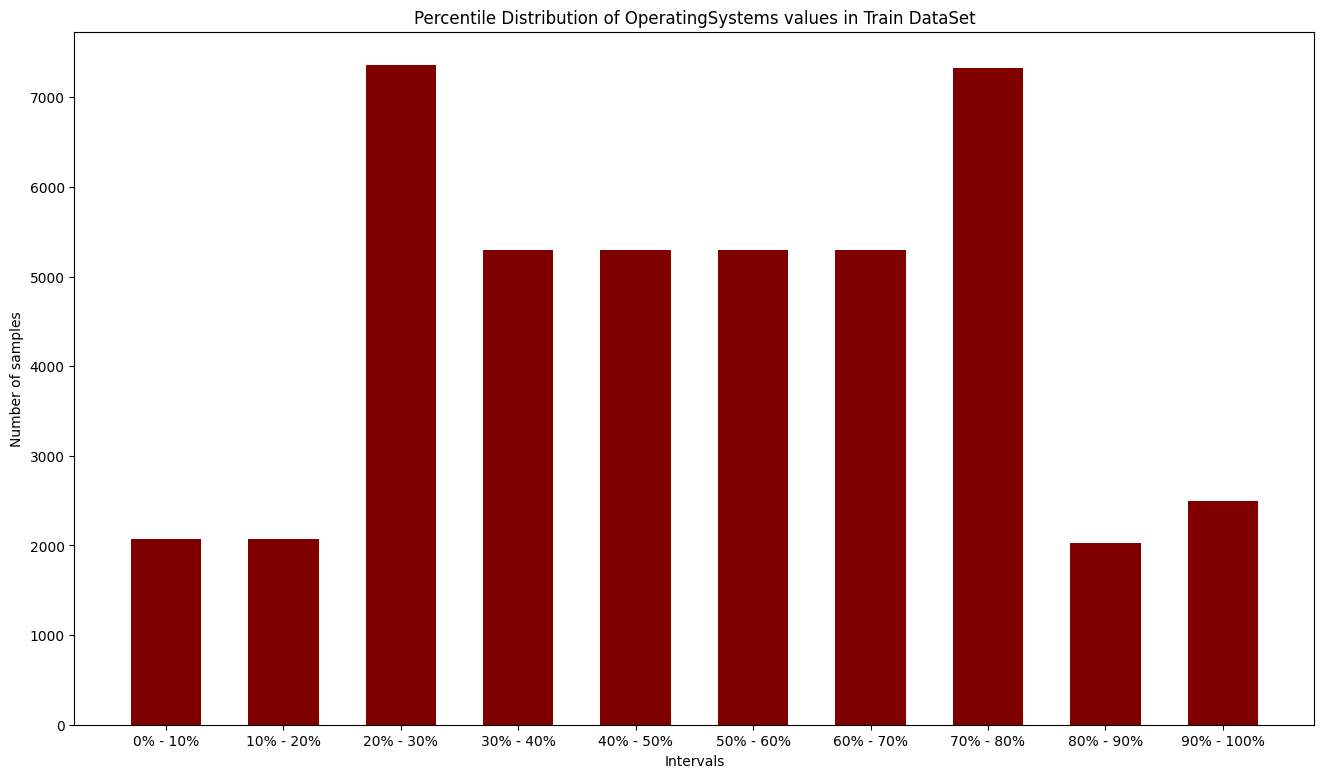

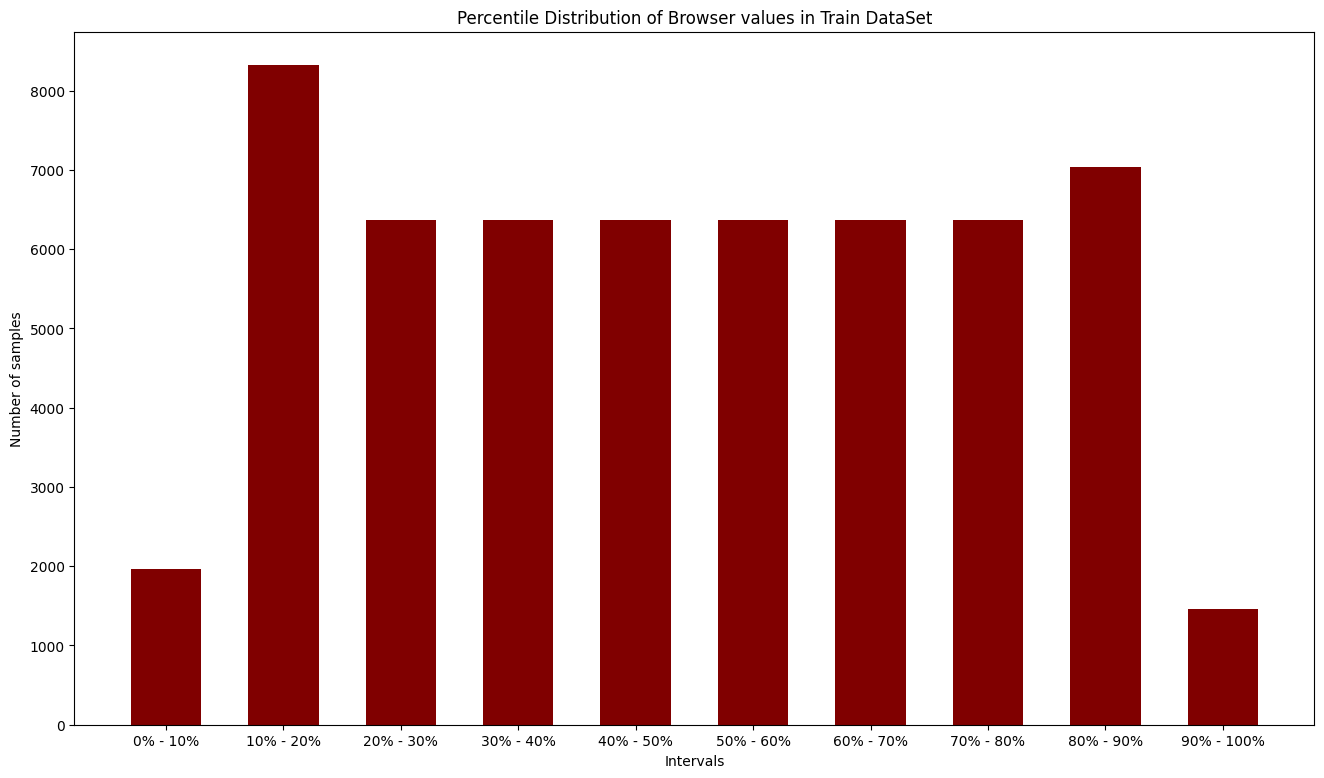

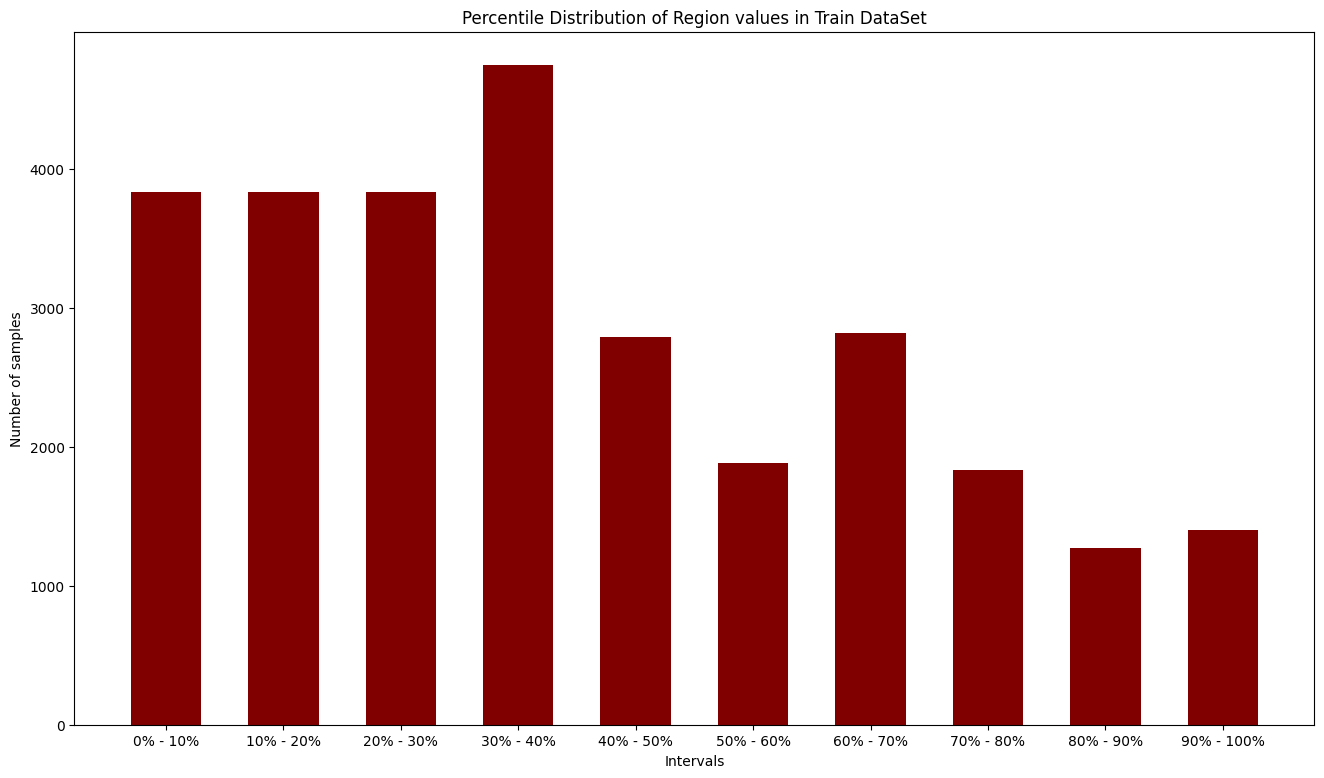

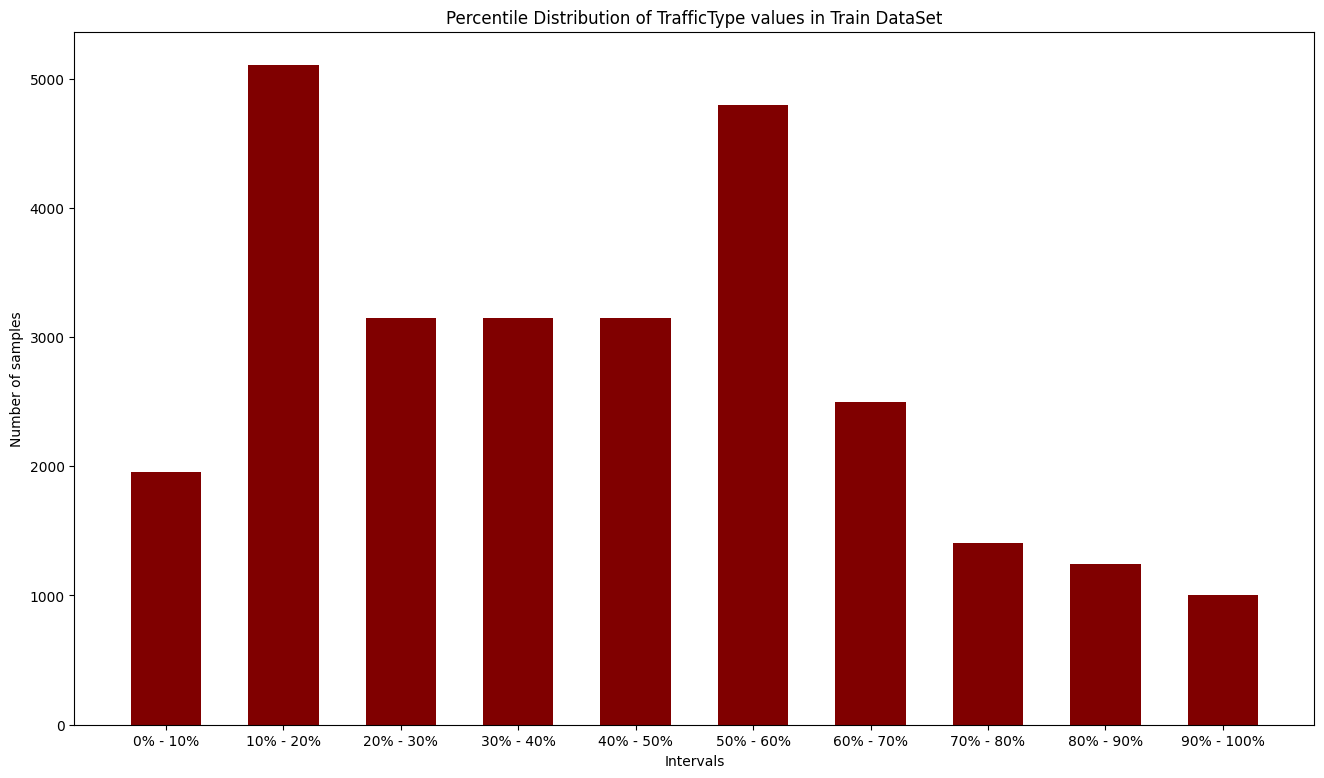

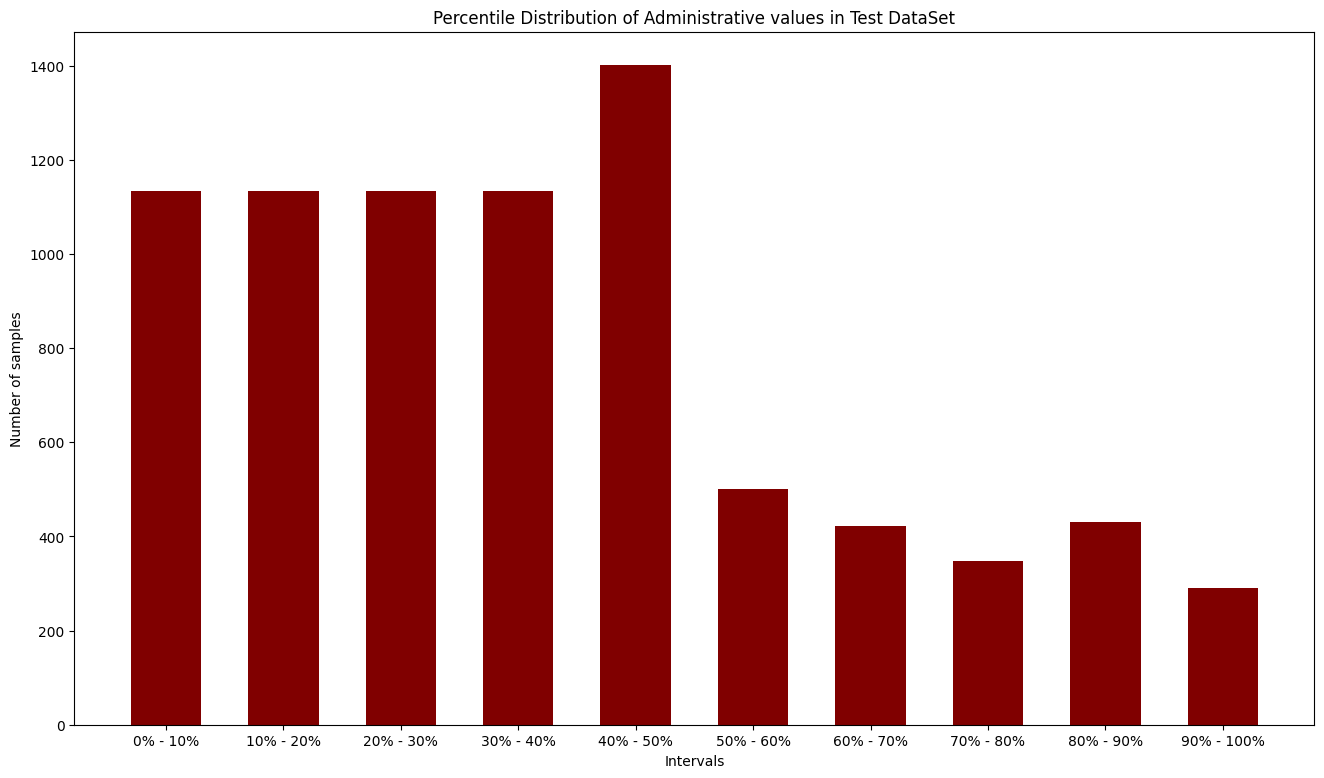

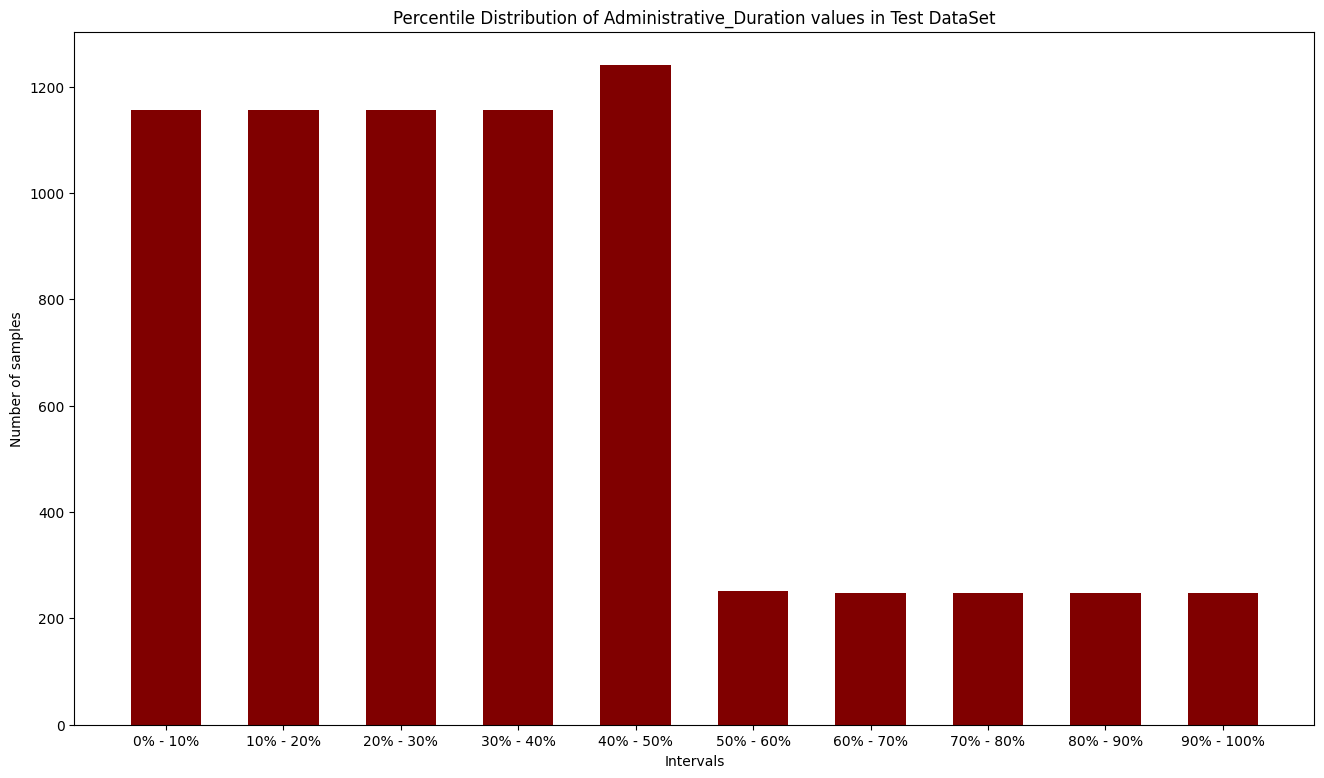

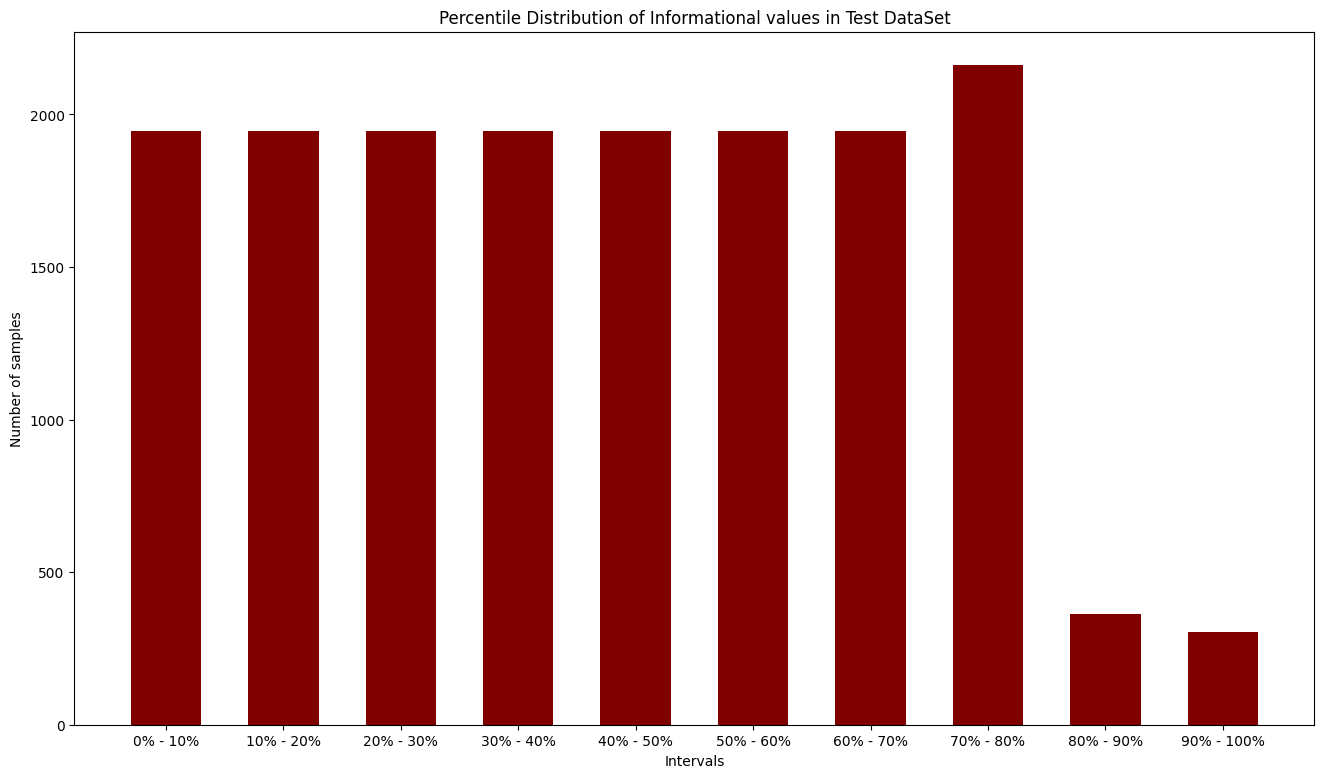

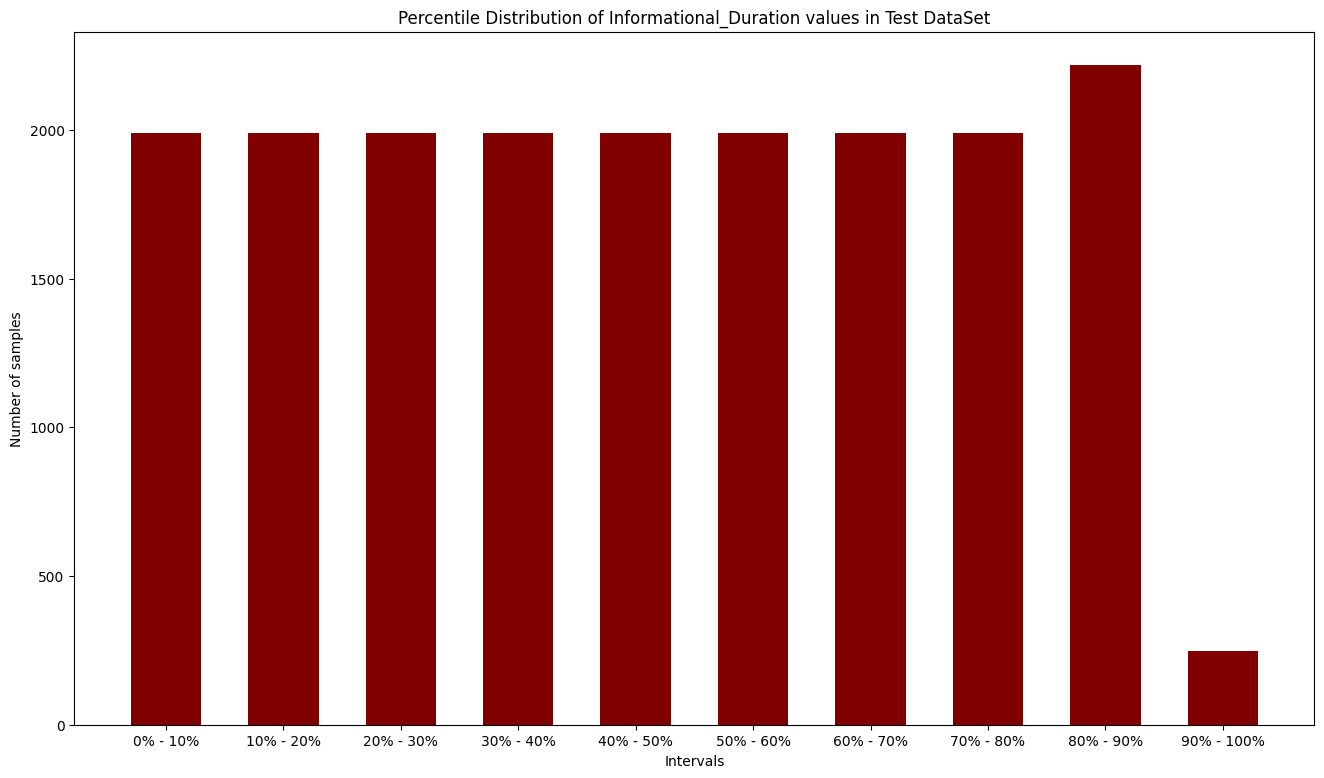

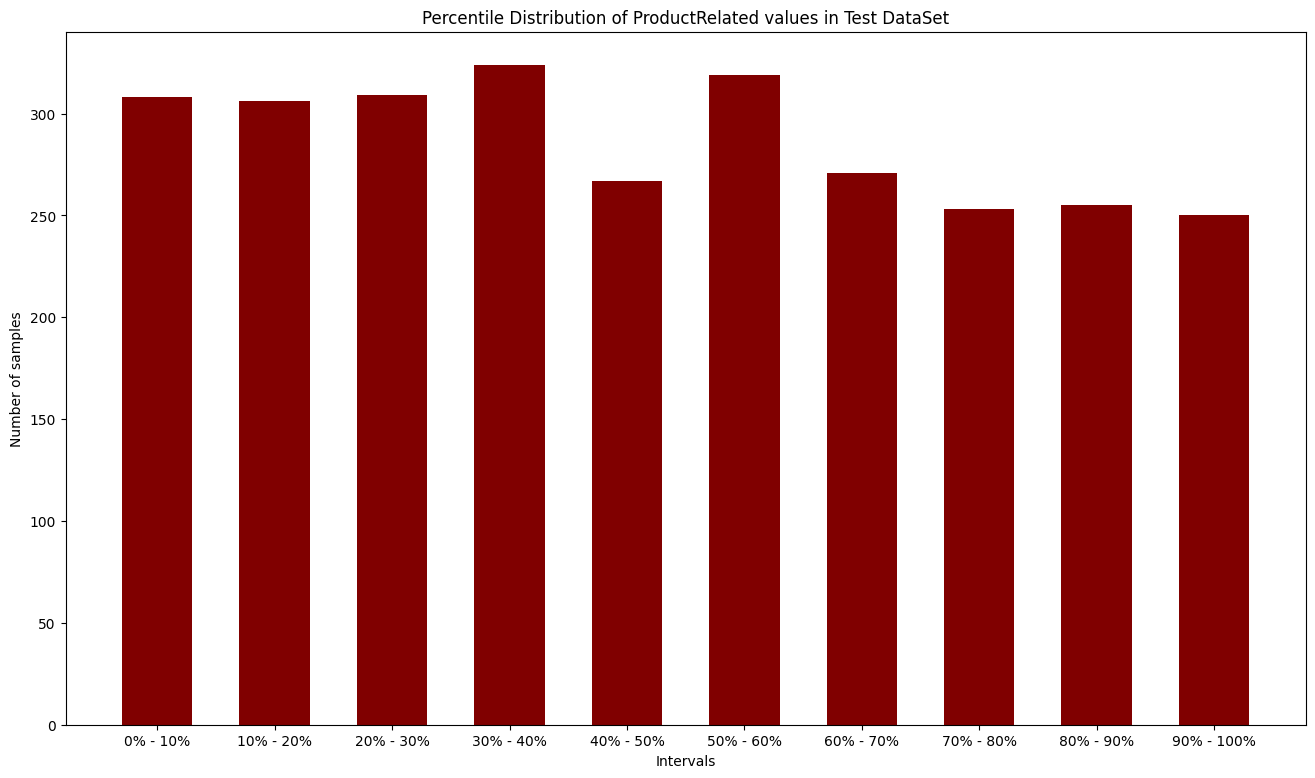

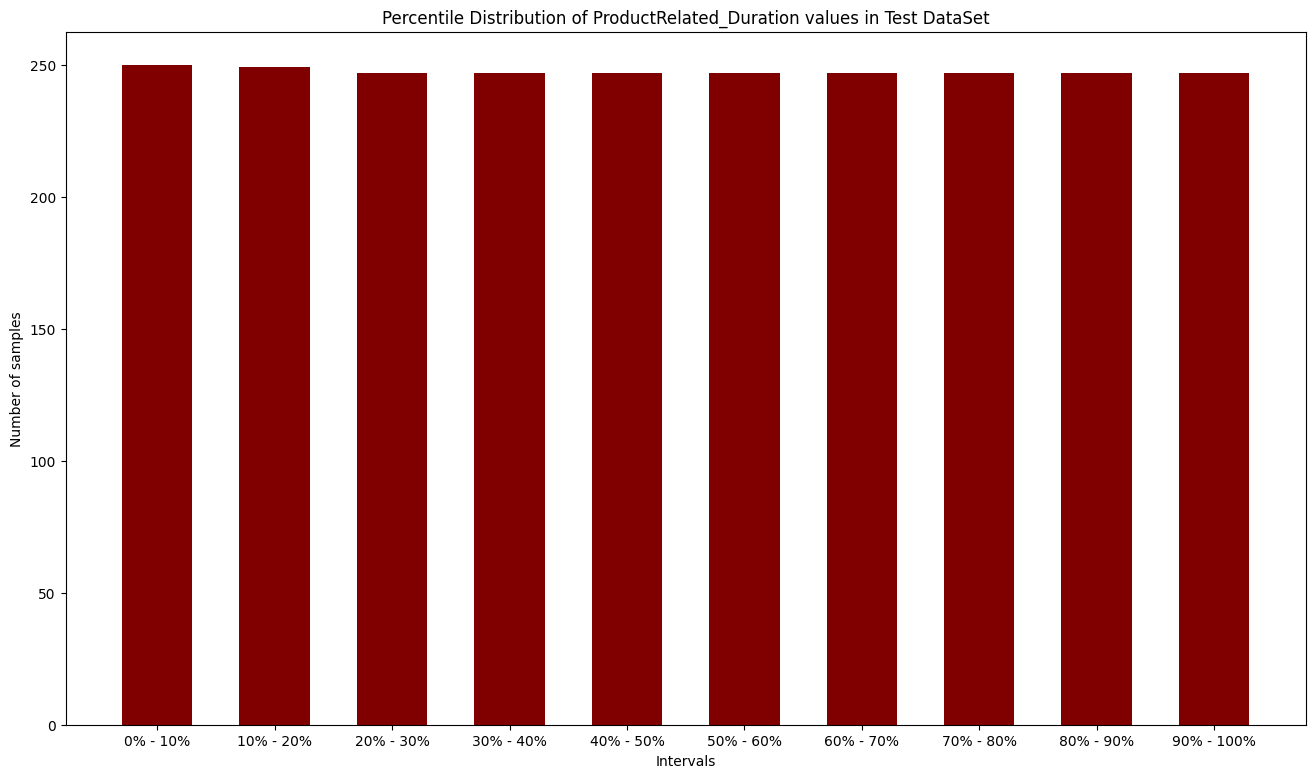

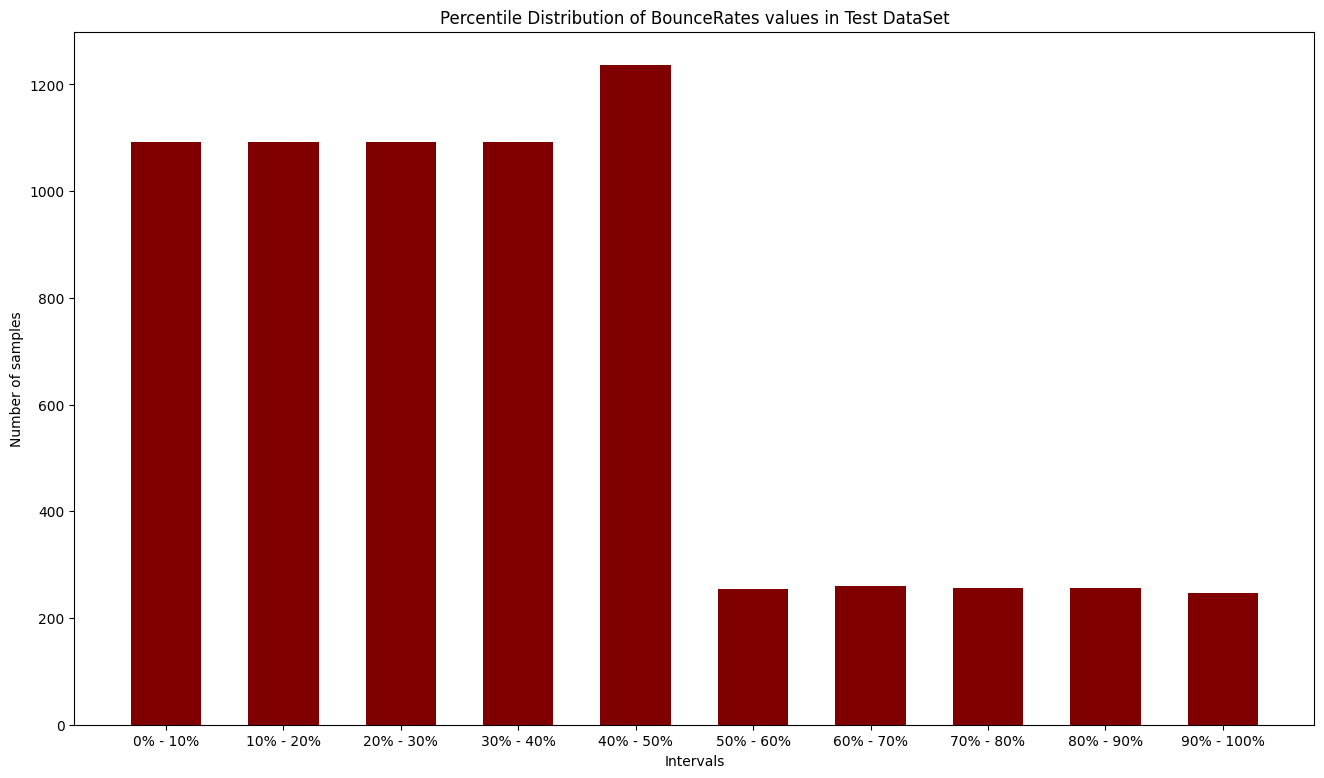

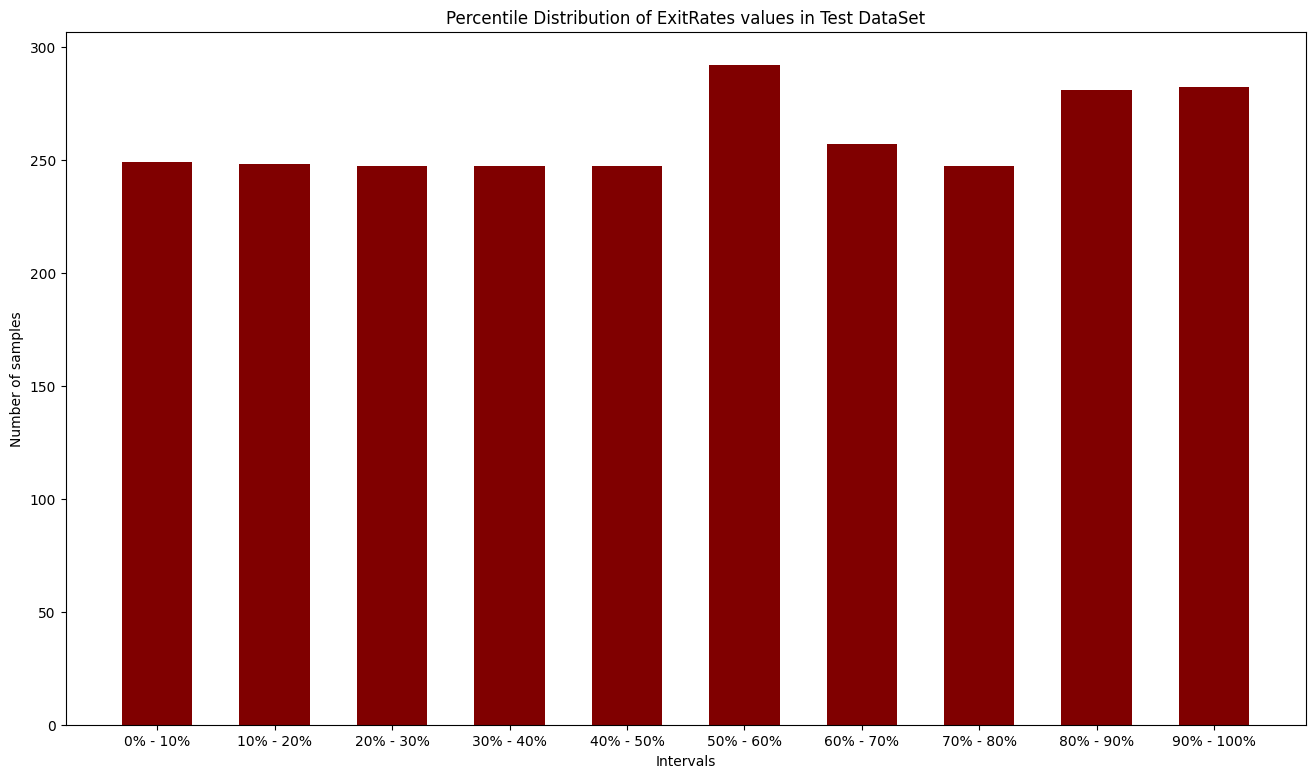

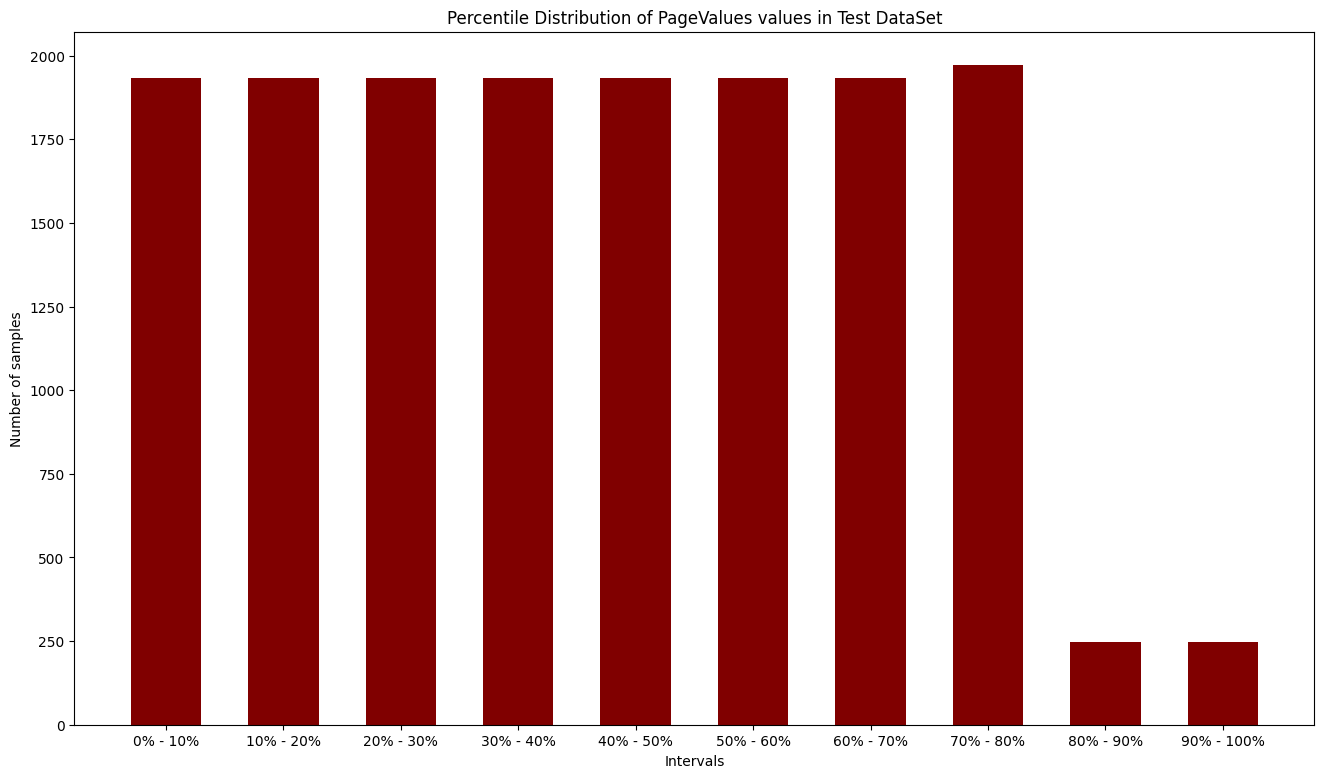

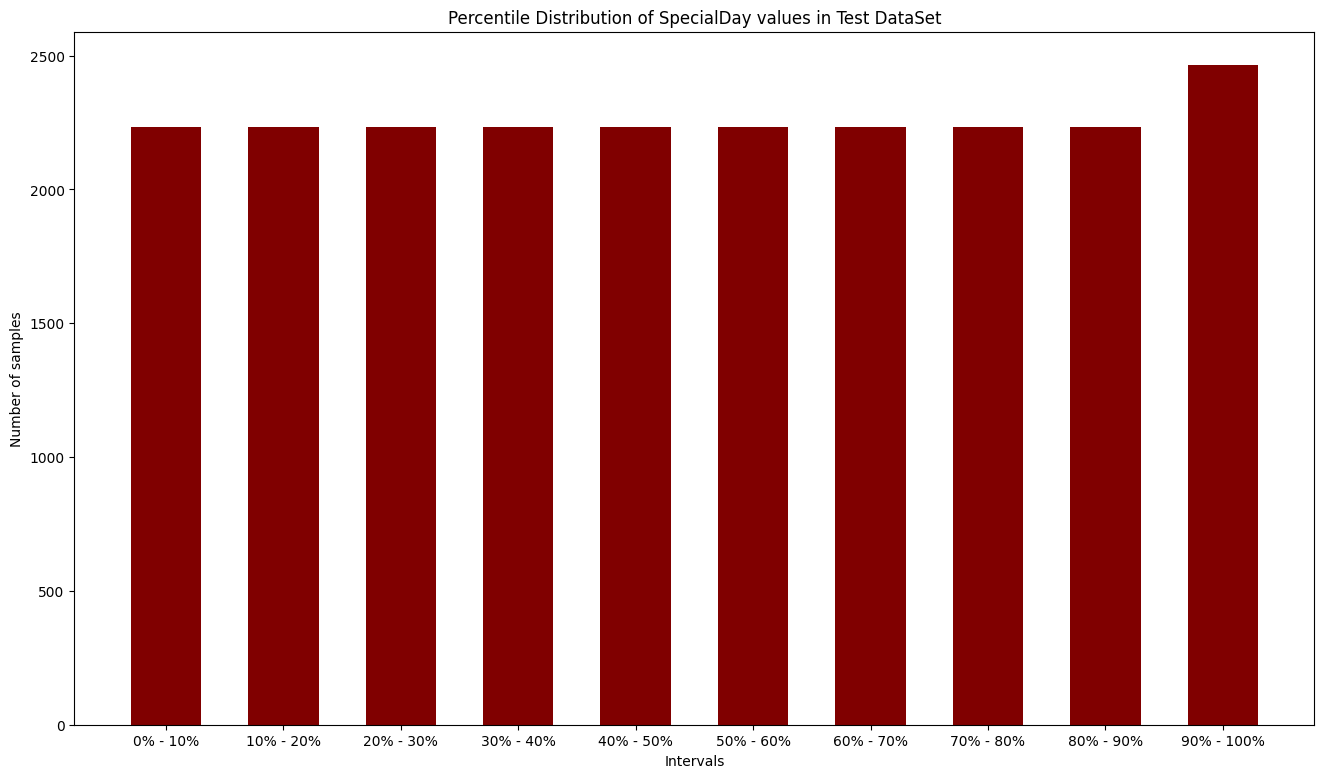

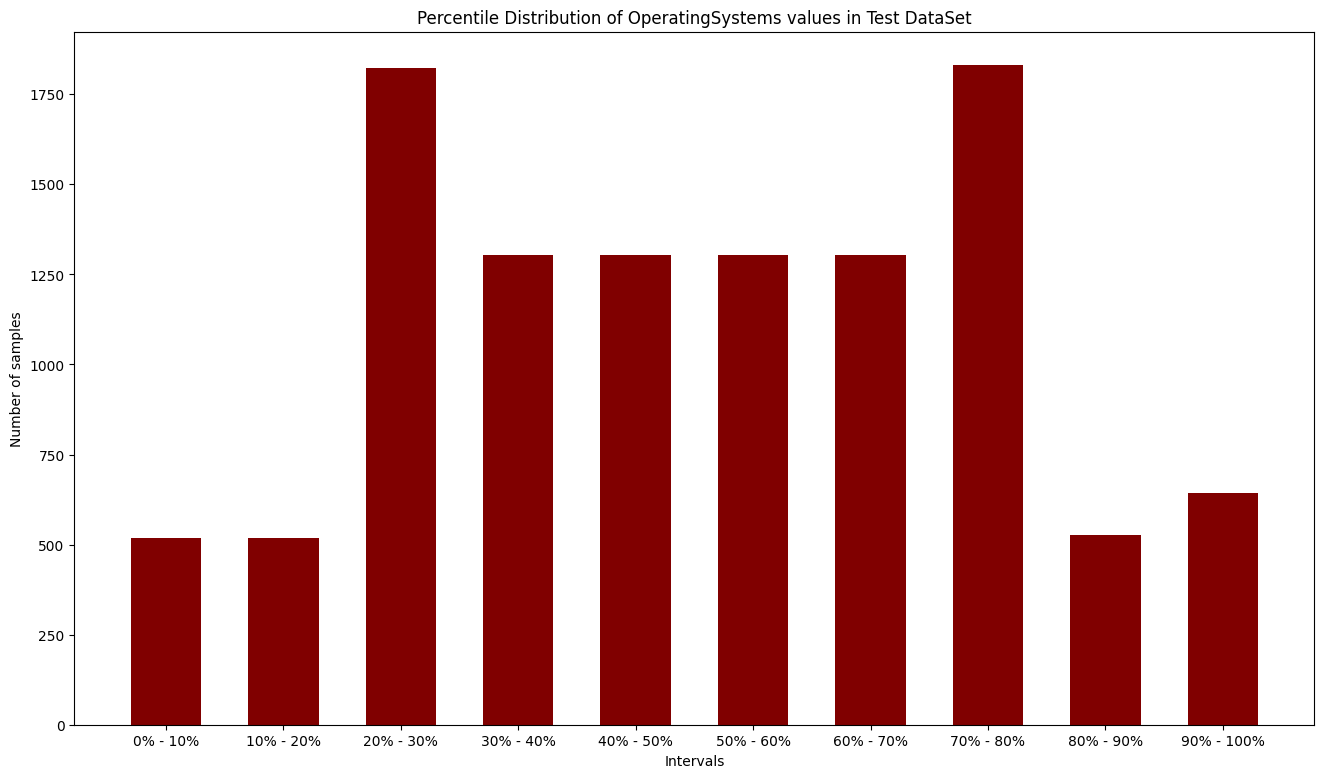

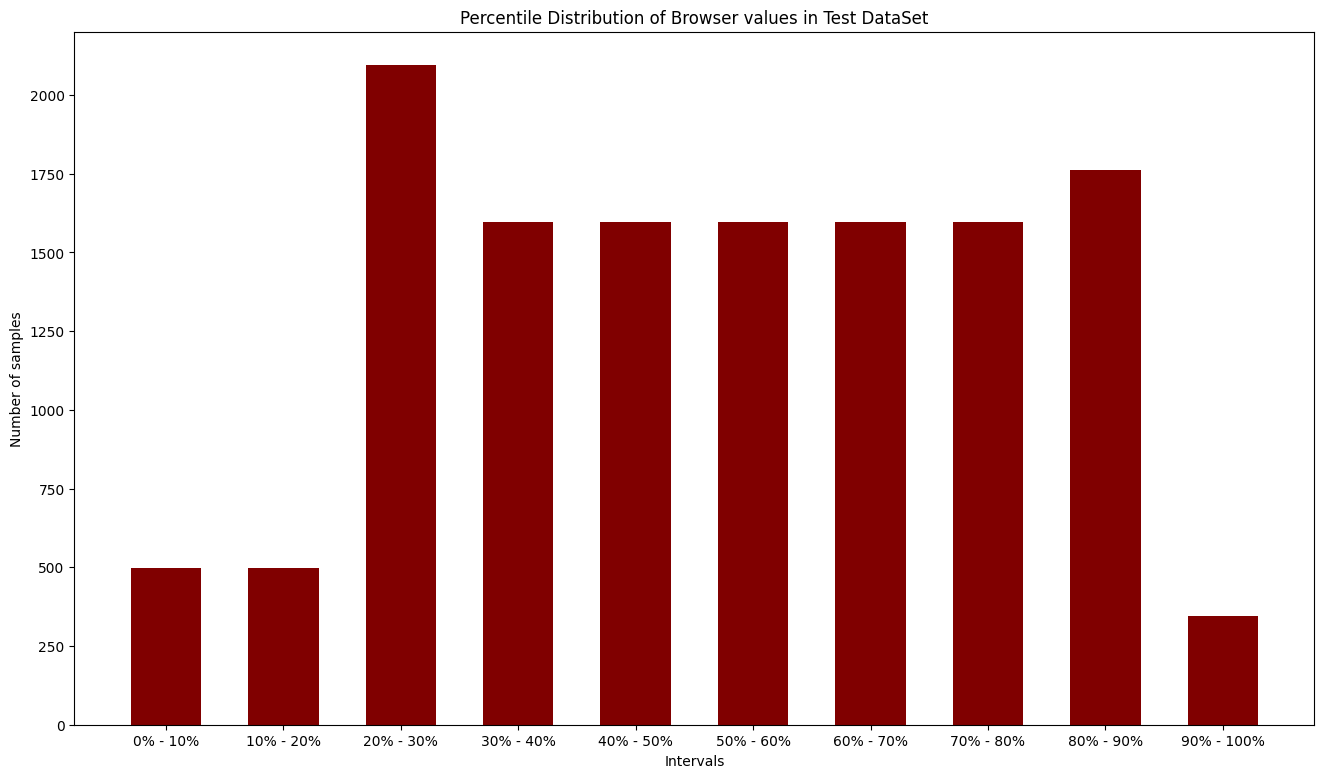

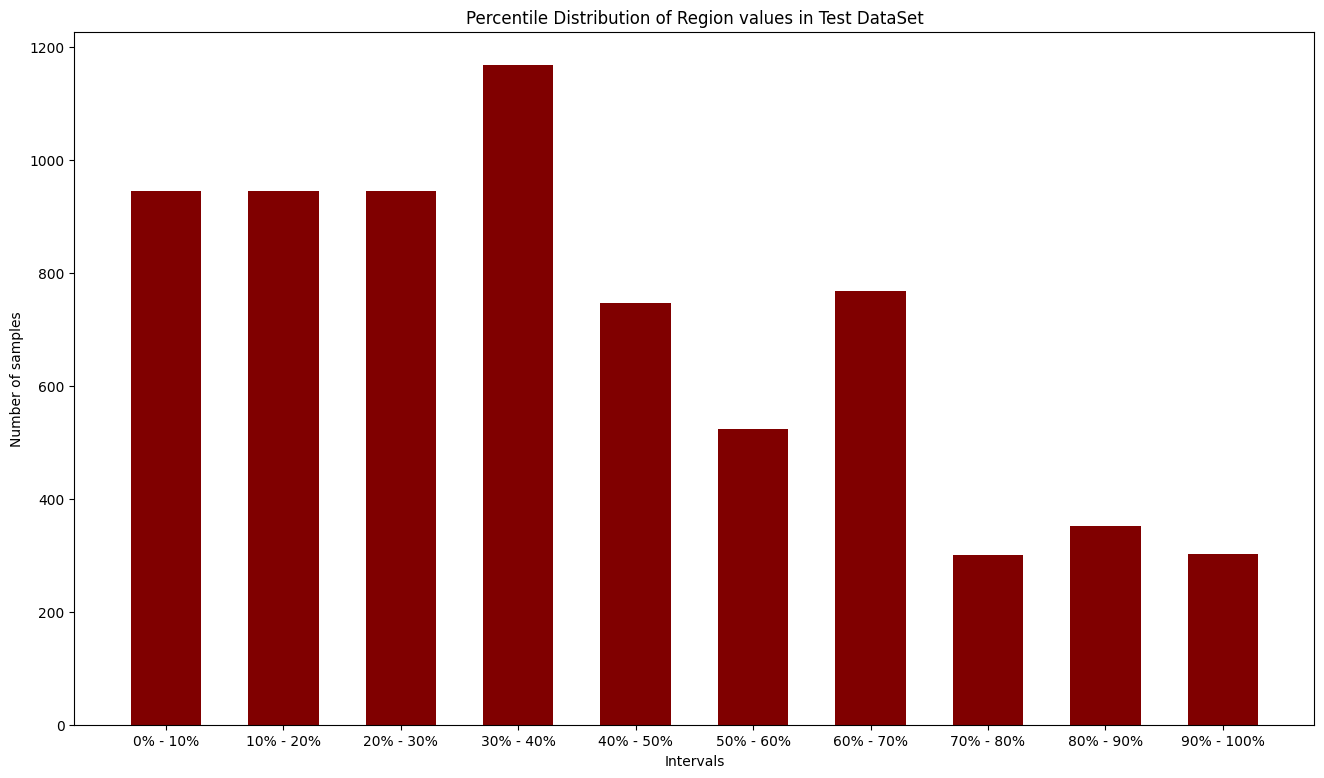

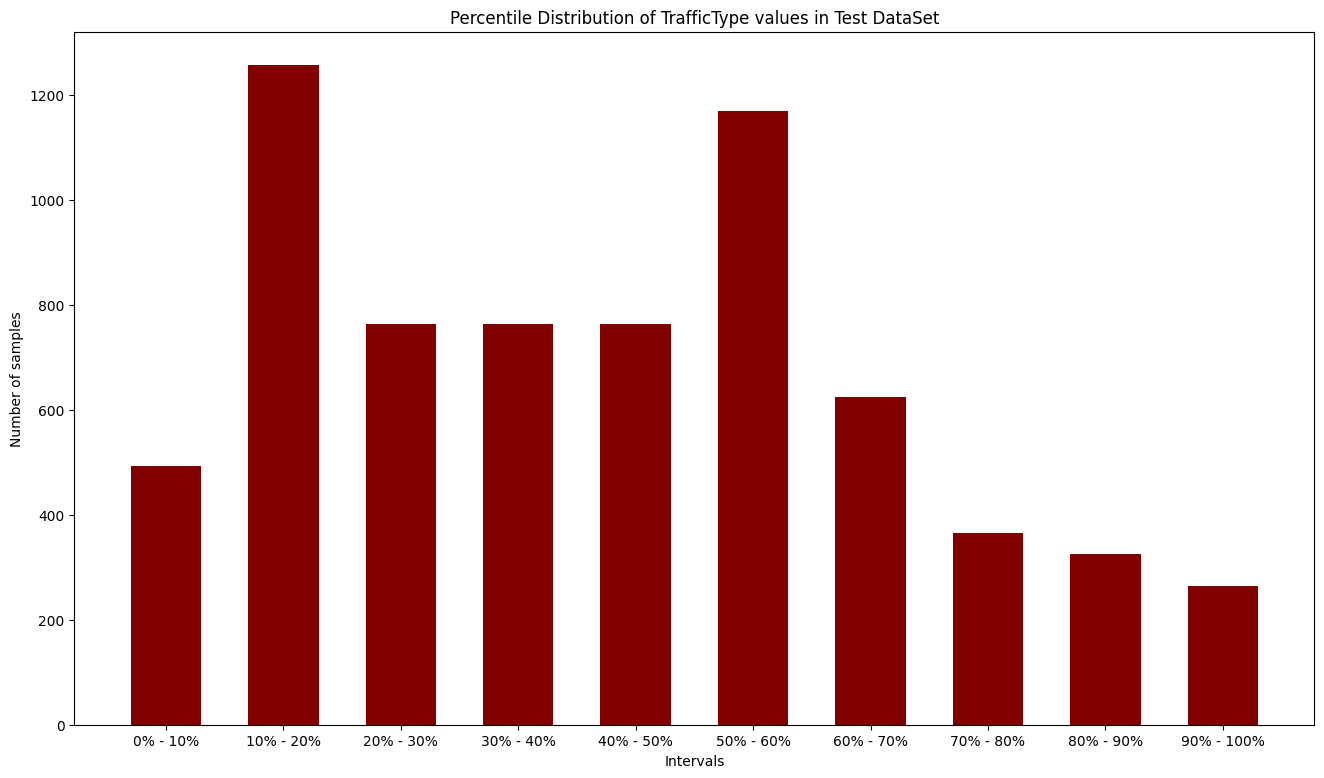

In [234]:
def plot_func(num_samples_dict, attribute, type):
    data = {}

    index = 0
    for elem in num_samples_dict:
        curr_key = "{}% - {}%".format(index * 10, (index + 1) * 10)
        data[curr_key] = elem
        index = index + 1

    intervals = list(data.keys())
    values = list(data.values())

    plt.figure(figsize = (16, 9))
    plt.bar(intervals, values, color ='maroon', 
        width = 0.6)
    plt.xlabel("Intervals")
    plt.ylabel("Number of samples")
    plt.title("Percentile Distribution of {} values in {} DataSet".format(attribute, type))
    plt.show()

for elem in numerical_attributes:
    plot_func(num_samples_dict_train[elem], elem, "Train")

for elem in numerical_attributes:
    plot_func(num_samples_dict_test[elem], elem, "Test")

<Axes: xlabel='Weekend'>

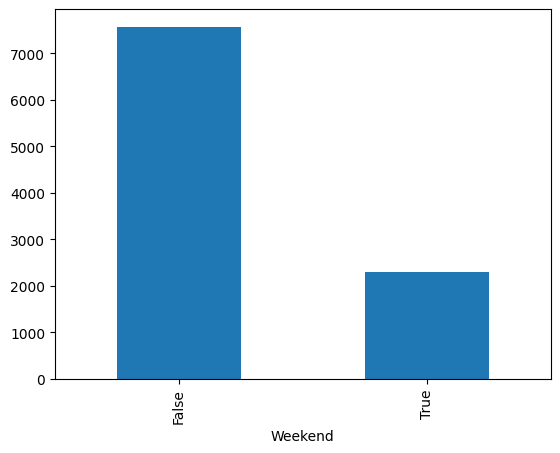

In [41]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[1][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Weekend'>

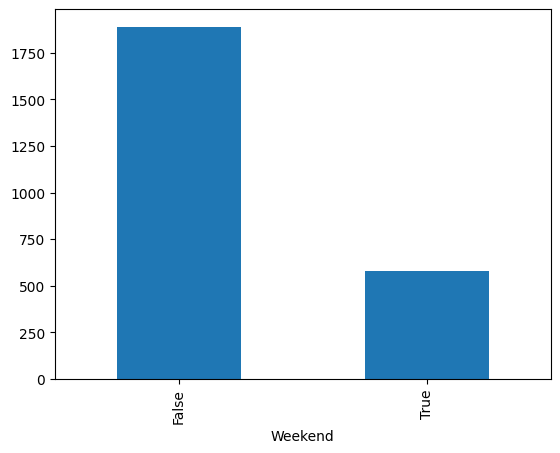

In [42]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[1][0]].value_counts().plot(kind='bar')

<Axes: xlabel='VisitorType'>

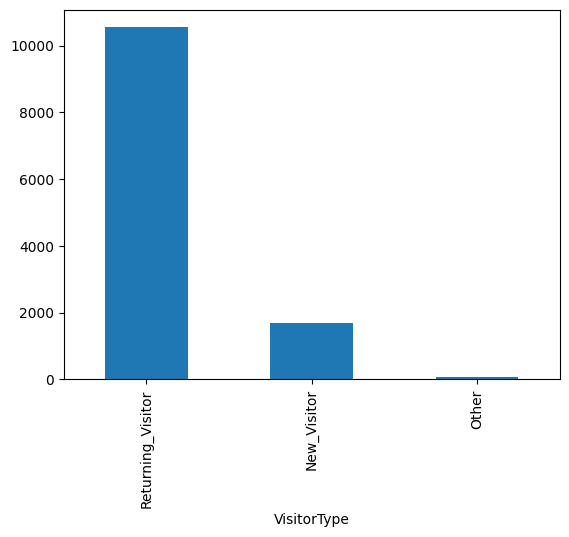

In [23]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[2][0]].value_counts().plot(kind='bar')

<Axes: xlabel='VisitorType'>

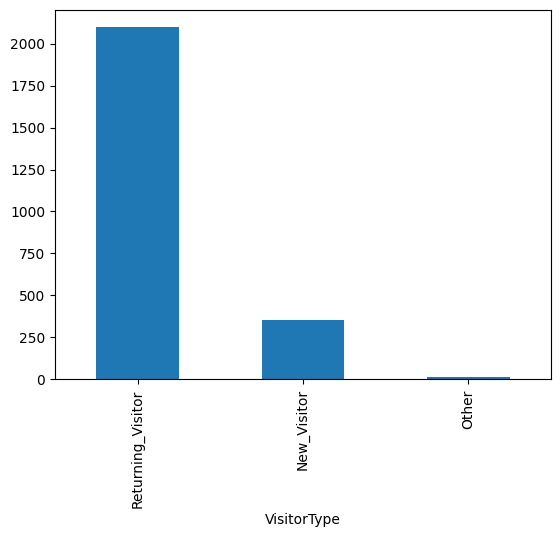

In [43]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[2][0]].value_counts().plot(kind='bar')

<Axes: xlabel='TrafficType'>

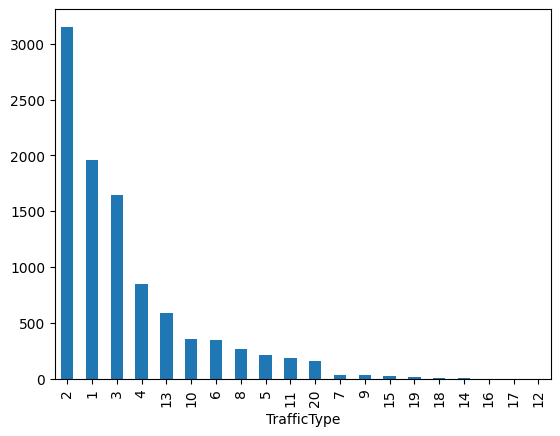

In [46]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[3][0]].value_counts().plot(kind='bar')

<Axes: xlabel='TrafficType'>

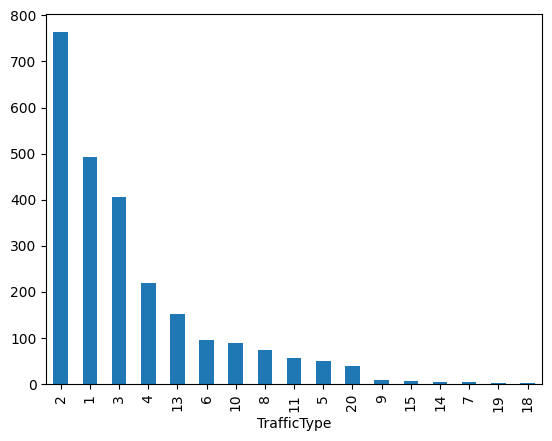

In [47]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[3][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Region'>

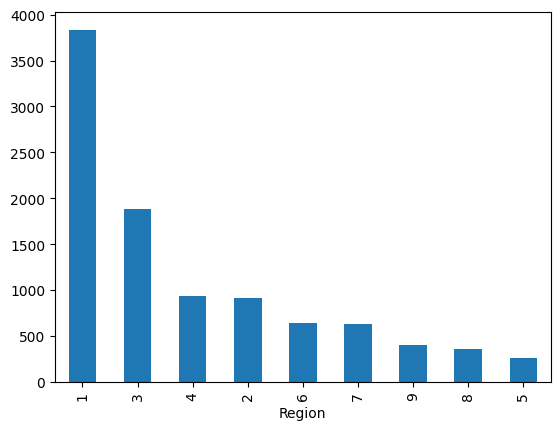

In [48]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[4][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Region'>

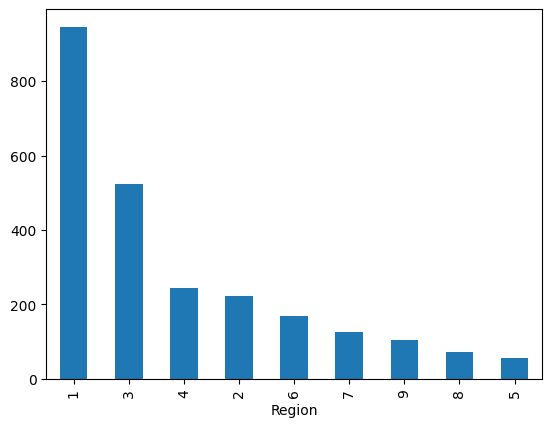

In [49]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[4][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Browser'>

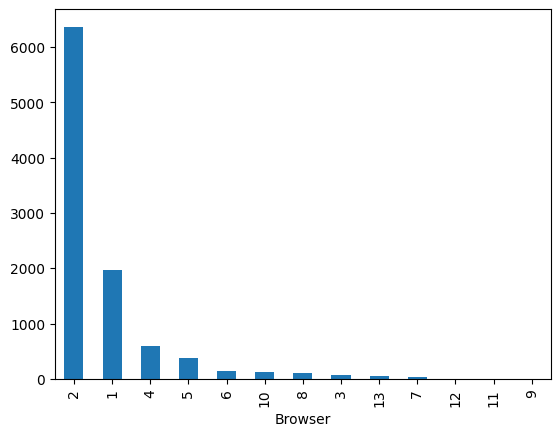

In [50]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[5][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Browser'>

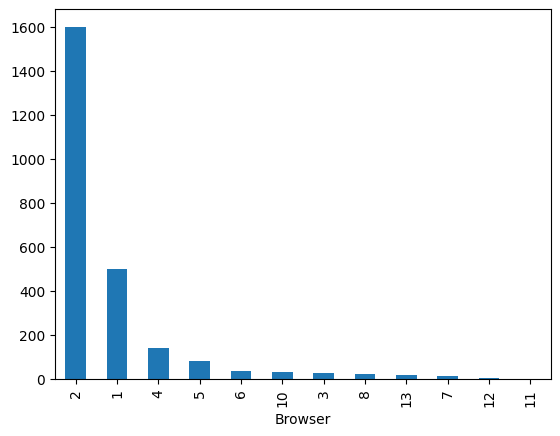

In [51]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[5][0]].value_counts().plot(kind='bar')

<Axes: xlabel='OperatingSystems'>

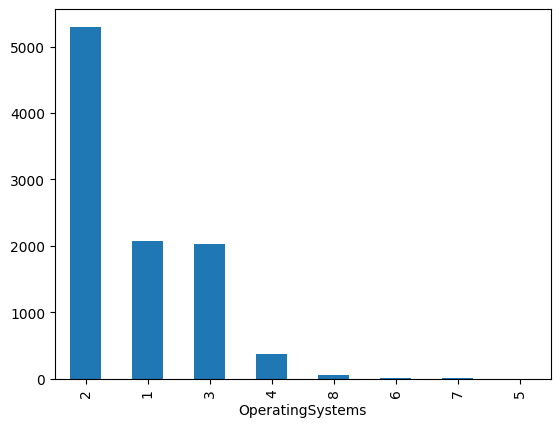

In [55]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[6][0]].value_counts().plot(kind='bar')

<Axes: xlabel='OperatingSystems'>

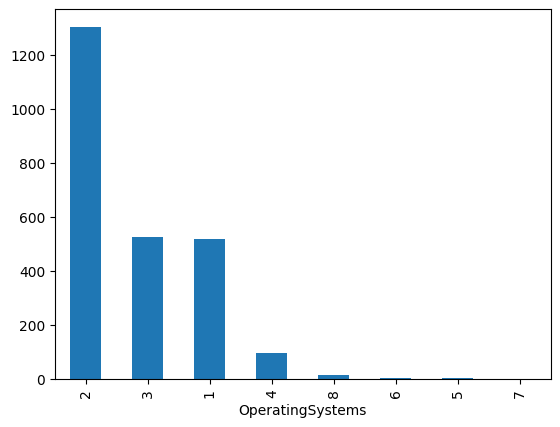

In [56]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[6][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Month'>

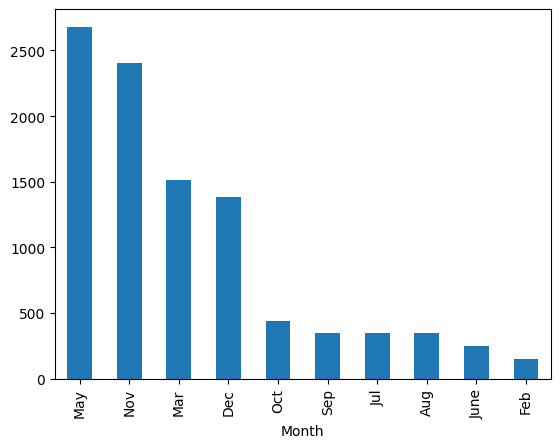

In [57]:
ml_dic_div[rand_test_num]["X"]["train"][categorical_attributes[7][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Month'>

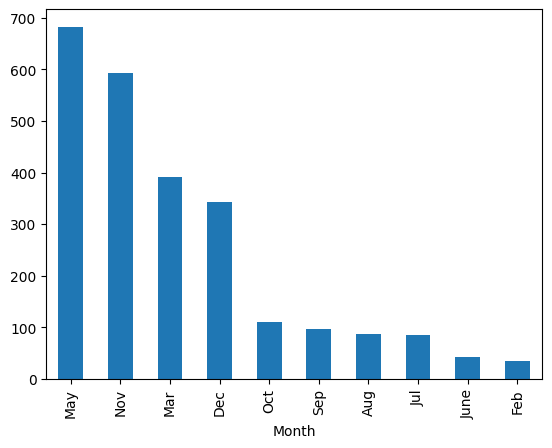

In [58]:
ml_dic_div[rand_test_num]["X"]["test"][categorical_attributes[7][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Revenue'>

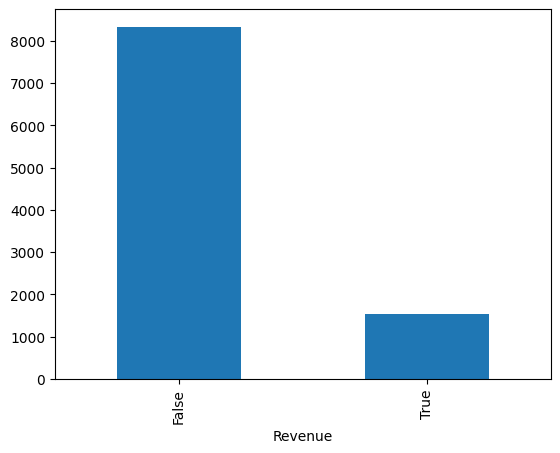

In [60]:
ml_dic_div[rand_test_num]["T"]["train"][categorical_attributes[0][0]].value_counts().plot(kind='bar')

<Axes: xlabel='Revenue'>

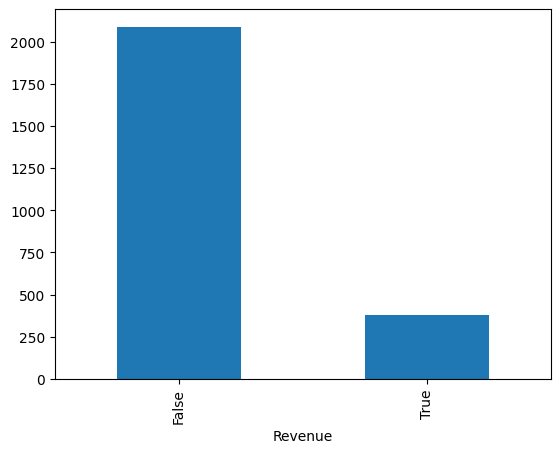

In [61]:
ml_dic_div[rand_test_num]["T"]["test"][categorical_attributes[0][0]].value_counts().plot(kind='bar')

Point-Biserial Correlation value for attribute Administrative : 0.13891709415067247
P-value for attribute Administrative : 3.5197598377762157e-54
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Administrative_Duration : 0.09358671905704398
P-value for attribute Administrative_Duration : 2.1465136347391026e-25
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Informational : 0.09520034257205935
P-value for attribute Informational : 3.174034311253924e-26
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute Informational_Duration : 0.0703445023459854
P-value for attribute Informational_Duration : 5.282870860711972e-15
------------------------------------------------------------------------------
Point-Biserial Correlation value for attribute ProductRelated : 0.15853

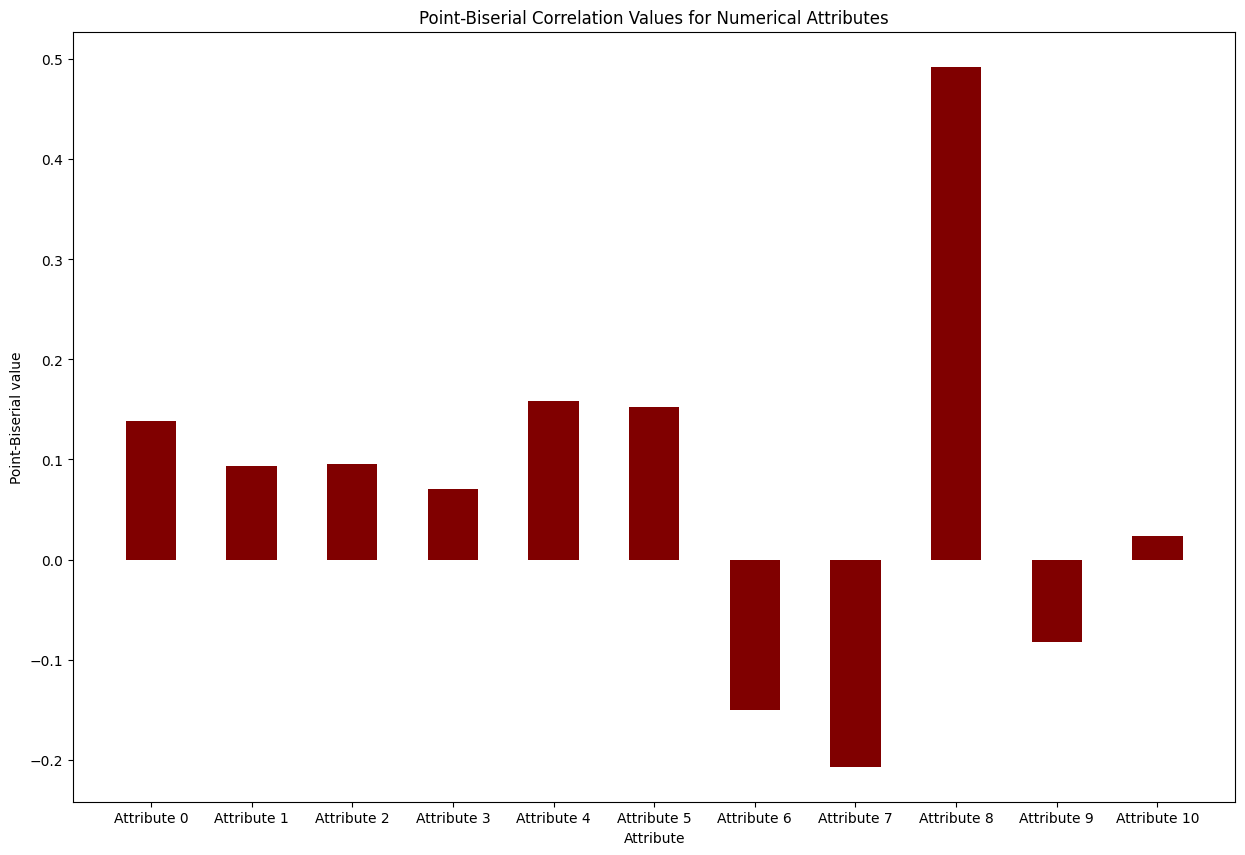

In [51]:
pts_biserial = []

for elem in numerical_attributes:
    p_value = stats.pointbiserialr(data["Revenue"], data[elem])[1]
    biserial_val = stats.pointbiserialr(data["Revenue"], data[elem])[0]
    if p_value <= 0.05:
        pts_biserial.append((biserial_val, elem))
    print("Point-Biserial Correlation value for attribute {} : {}".format(elem,biserial_val))
    print("P-value for attribute {} : {}".format(elem, p_value))
    print("------------------------------------------------------------------------------")

info_dict = {}
index = 0
for elem in pts_biserial:
    curr_key = "Attribute {}".format(index)
    print(curr_key + " -> " + elem[1])
    info_dict[curr_key] = elem[0]
    index = index + 1

attrs = list(info_dict.keys())
values = list(info_dict.values())

plt.figure(figsize = (15, 10))
plt.bar(attrs, values, color ='maroon', 
        width = 0.5)

plt.xlabel("Attribute")
plt.ylabel("Point-Biserial value")
plt.title("Point-Biserial Correlation Values for Numerical Attributes")
plt.show()

Chi-Squared Statistical value for attribute Weekend : 10.58183514829754
P-value for attribute Weekend : 0.005037136192599038
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute VisitorType : 135.2519228192047
P-value for attribute VisitorType : 3.991223433643256e-29
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute TrafficType : 373.14556468814857
P-value for attribute TrafficType : 7.442024647470126e-67
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Region : 9.252751430579846
P-value for attribute Region : 0.4142778663586834
------------------------------------------------------------------------------
Chi-Squared Statistical value for attribute Browser : 27.71529940138156
P-value for attribute Browser : 0.00991396435211927
---------------------------------------------

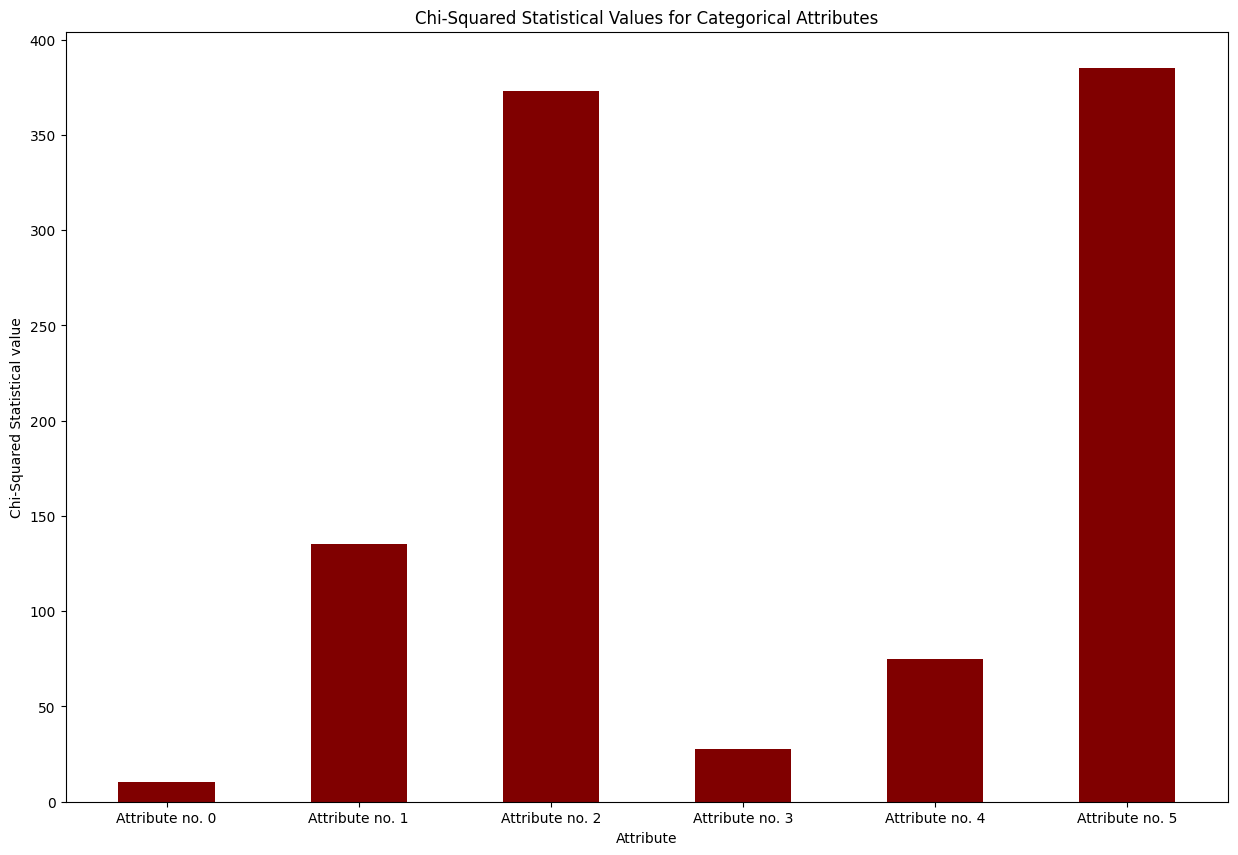

In [52]:
chi2_value = []

for elem in categorical_attributes:
    if elem[0] != "Revenue":
        chisqt = pd.crosstab(data.Revenue, data[elem[0]], margins=True)
        value = np.array([chisqt.iloc[0][:].values,
                  chisqt.iloc[1][:].values])
        p_value = chi2_contingency(value)[0:3][1]
        chi2_stat = chi2_contingency(value)[0:3][0]
        if p_value <= 0.05:
            chi2_value.append((chi2_stat, elem[0]))
        print("Chi-Squared Statistical value for attribute {} : {}".format(elem[0],chi2_stat))
        print("P-value for attribute {} : {}".format(elem[0], p_value))
        print("------------------------------------------------------------------------------")

info_dict = {}
index = 0
for elem in chi2_value:
    curr_key = "Attribute no. {}".format(index)
    print(curr_key + " -> " + elem[1])
    info_dict[curr_key] = elem[0]
    index = index + 1

attrs = list(info_dict.keys())
values = list(info_dict.values())

plt.figure(figsize = (15, 10))
plt.bar(attrs, values, color ='maroon', 
        width = 0.5)

plt.xlabel("Attribute")
plt.ylabel("Chi-Squared Statistical value")
plt.title("Chi-Squared Statistical Values for Categorical Attributes")
plt.show()


## Logistic Regression from Scratch

In [42]:
class LogisticRegression:
    
    def __init__(self, learning_rate=0.01, num_iterations=1250):

        self.learning_rate = learning_rate
        self.num_iterations = num_iterations


    def format_shape(self, X):

        intercept = np.ones((X.shape[0], 1))

        return np.concatenate((intercept, X), axis=1)

    def sigmoid_function(self, z):

        return [1 / (1 + np.exp(-elem)) if elem > 0 else np.exp(elem) / (1 + np.exp(elem)) for elem in z]
    
    def fit(self, X, y):

        X = self.format_shape(X)

        self.W = np.random.randn(X.shape[1])
        
        for i in range(self.num_iterations):

            z = np.dot(X, self.W)

            y_pred = self.sigmoid_function(z)
            
            gradient = np.dot(X.T, (y_pred - y))

            self.W -= self.learning_rate * gradient
    
    def predict_prob(self, X):

        X = self.format_shape(X)

        return self.sigmoid_function(np.dot(X, self.W))

    def predict(self, X):

        classes = []
        for elem in self.predict_prob(X):
            if elem > 0.5:
                classes.append(1)
            else:
                classes.append(0)
        return np.asarray(classes)

def process_train_test_data(num, target, ml_dic_div_par, scaler):

    encoder = LabelEncoder()
    for elem in categorical_attributes:
        if elem[0] != target:
            ml_dic_div_par[num]["X"]["train"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["X"]["train"][elem[0]])
            ml_dic_div_par[num]["X"]["test"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["X"]["test"][elem[0]])

        else:
            ml_dic_div_par[num]["T"]["train"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["T"]["train"][elem[0]])
            ml_dic_div_par[num]["T"]["test"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["T"]["test"][elem[0]])

    if scaler is not None:
        ml_dic_div_par[num]["X"]["train"] = scaler.fit_transform(ml_dic_div_par[num]["X"]["train"])
        ml_dic_div_par[num]["X"]["test"] = scaler.transform(ml_dic_div_par[num]["X"]["test"])
    
    return ml_dic_div_par[num]["X"]["train"], ml_dic_div_par[num]["T"]["train"][target].to_numpy(), ml_dic_div_par[num]["X"]["test"], ml_dic_div_par[num]["T"]["test"][target].to_numpy()

def logistic_regression_from_scratch(num_test, target, scaler, model):
    ml_logistic_reg = deepcopy(ml_dic_div)
    X_train, T_train, X_test, T_test = process_train_test_data(num_test, target, ml_logistic_reg, scaler)

    model.fit(X_train, T_train)
    y_test = model.predict(X_test)

    print("\n")
    print(classification_report(T_test, y_test))
    print("****************************************************************************\n")

In [157]:
target_attr = "Revenue"
model = LogisticRegression(learning_rate=0.01, num_iterations=1250)

for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    for test_num in range(num_div):
        print("Current split: {} & Current scaler: {}".format(test_num, scaler))
        logistic_regression_from_scratch(test_num, target_attr, scaler, model)

Current split: 0 & Current scaler: MinMaxScaler()


              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2089
           1       0.69      0.49      0.57       377

    accuracy                           0.89      2466
   macro avg       0.80      0.72      0.75      2466
weighted avg       0.88      0.89      0.88      2466

****************************************************************************

Current split: 1 & Current scaler: MinMaxScaler()


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2089
           1       0.60      0.68      0.64       377

    accuracy                           0.88      2466
   macro avg       0.77      0.80      0.78      2466
weighted avg       0.89      0.88      0.88      2466

****************************************************************************

Current split: 2 & Current scaler: MinMaxScaler()


              precision    recall 

## Logistic Regression using sklearn

In [15]:
def logistic_regression_sklearn(num_test, target, scaler, model):

    ml_logistic_reg = deepcopy(ml_dic_div)
    X_train, T_train, X_test, T_test = process_train_test_data(num_test, target, ml_logistic_reg, scaler)

    model.fit(X_train, T_train)
    y_test = model.predict(X_test)

    print("\n")
    print(classification_report(T_test, y_test))
    print("****************************************************************************\n")

In [243]:
target_attr = "Revenue"
model = LogisticRegression_sklearn(solver='liblinear', random_state=0, max_iter=1250)

for scaler in [MinMaxScaler(), StandardScaler(), RobustScaler()]:
    for test_num in range(num_div):
        print("Current split: {} & Current scaler: {}".format(test_num, scaler))
        logistic_regression_sklearn(test_num, target_attr, scaler, model)

Current split: 0 & Current scaler: MinMaxScaler()


              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2089
           1       0.73      0.27      0.39       377

    accuracy                           0.87      2466
   macro avg       0.81      0.62      0.66      2466
weighted avg       0.86      0.87      0.85      2466

****************************************************************************

Current split: 1 & Current scaler: MinMaxScaler()


              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2089
           1       0.73      0.27      0.39       377

    accuracy                           0.87      2466
   macro avg       0.81      0.62      0.66      2466
weighted avg       0.86      0.87      0.85      2466

****************************************************************************

Current split: 2 & Current scaler: MinMaxScaler()


              precision    recall 

## Decision Tree from Scratch

In [88]:
class Node:

    def __init__(self, label):

        self.label = label

        self.children = {}

    def display(self, string):

        print(string + str(self.label))
        string += "\t"
        if self.children:
            for key, value in self.children.items():
                print(string + key)
                value.display(string + "\t")

class DecisionTreeClassifier:
    
    def entropy(self, X):

        classes = {}
        for elem in X:
            curr_class = elem["CLASS"]
            if curr_class in classes:
                classes[curr_class] += 1
            else:
                classes[curr_class] = 1
        nums = []
        for dummy, num in classes.items():
            nums.append(num / len(X) * log2(num / len(X)))
        result = sum(nums)
        return -result

    def gain(self, left, right, attr):

        left_gain = -inf
        right_gain = -inf

        attr_values = set()
        for elem in left:
            attr_values.add(elem[attr])
        l = len(left)
        comp_gain = self.entropy(left)
        for val in attr_values:
            X_new = []
            for iter in left:
                if iter[attr] == val:
                    X_new.append(iter)
            comp_gain -= len(X_new) * self.entropy(X_new) / l
        if comp_gain > left_gain:
            left_gain = comp_gain

        attr_values = set()
        for elem in right:
            attr_values.add(elem[attr])
        l = len(right)
        comp_gain = self.entropy(right)
        for val in attr_values:
            X_new = []
            for iter in right:
                if iter[attr] == val:
                    X_new.append(iter)
            comp_gain -= len(X_new) * self.entropy(X_new) / l
        if comp_gain > right_gain:
            right_gain = comp_gain

        if right_gain > left_gain:
            return right_gain
        return left_gain

    def mostCommonClass(self, X):

        var = []
        for elem in X:
            var.append(elem["CLASS"])
        most_common = Counter(var).most_common()
        return most_common[0][0]

    def decisionTree(self, d, X, A):

        if not A or d == 0:
            return Node(int(self.mostCommonClass(X)))

        rand_attr = choice(A)
        attr_values = set()
        for elem in X:
            attr_values.add(elem[rand_attr])
        new_A = deepcopy(A)
        new_A.remove(rand_attr)
        new_node = Node(rand_attr)
        new_node.children = {}

        if rand_attr in numerical_attributes and rand_attr not in categorical_attributes:
            thresholds = np.percentile(list(attr_values), [elem for elem in range(0, 100, 10)])
            best_threshold = np.percentile(list(attr_values), 50)
            best_info_gain = 0

            for threshold in thresholds:
                left = [elem for elem in X if elem[rand_attr] <= threshold]
                right = [elem for elem in X if elem[rand_attr] > threshold]
                info_gain = self.gain(left, right, rand_attr)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_threshold = threshold

            left = [elem for elem in X if elem[rand_attr] <= best_threshold]
            right = [elem for elem in X if elem[rand_attr] > best_threshold]

            if left:
                left_node = self.decisionTree(d - 1, left, new_A)
                new_node.children.update({f' <= {best_threshold}' : left_node})

            if right:
                right_node = self.decisionTree(d - 1, right, new_A)
                new_node.children.update({f' > {best_threshold}' : right_node})
        
            return new_node

        else:
            for val in attr_values:
                new_X = []
                for elem in X:
                    if elem[rand_attr] == val:
                        new_X.append(elem)
                node = self.decisionTree(d - 1, new_X, new_A)
                new_node.children.update({val : node})
            return new_node

    
    def evaluate(self, tree, example):

        node = tree.children
        leaf = {}
        if node == leaf:
            return tree.label

        if example[tree.label] not in node:
            expan = list(node.values())
            return self.evaluate(expan[0], example)
        val_label = example[tree.label]
        return self.evaluate(node[val_label], example)
    
    def predict(self, tree, X):

        y_pred = []
        evaluator = self.evaluate
        
        for x in X:
            y_pred.append(evaluator(tree, x))

        return np.asarray(y_pred)
    
def process_train_test_data_decision_tree(num, ml_dic_div_par, scaler, target):
    
    encoder = LabelEncoder()
    train_last_col = [0 if elem == False else 1 for elem in (ml_dic_div_par[num]["X"]["train_labels"])[target]]

    test_last_col = [0 if elem == False else 1 for elem in (ml_dic_div_par[num]["X"]["test_labels"])[target]]

    for elem in categorical_attributes:
        ml_dic_div_par[num]["X"]["train_labels"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["X"]["train_labels"][elem[0]])
        ml_dic_div_par[num]["X"]["test_labels"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["X"]["test_labels"][elem[0]])

        if elem[0] == target:
            ml_dic_div_par[num]["T"]["test"][elem[0]] = encoder.fit_transform(ml_dic_div_par[num]["T"]["test"][elem[0]])


    if scaler is not None:
        ml_dic_div_par[num]["X"]["train_examples"] = scaler.fit_transform(ml_dic_div_par[num]["X"]["train_labels"])
        ml_dic_div_par[num]["X"]["test_examples"] = scaler.transform(ml_dic_div_par[num]["X"]["test_labels"])
    else:
        ml_dic_div_par[num]["X"]["train_examples"] = ml_dic_div_par[num]["X"]["train_labels"]
        ml_dic_div_par[num]["X"]["test_examples"] = ml_dic_div_par[num]["X"]["test_labels"]

    train_df = pd.DataFrame(ml_dic_div_par[num]["X"]["train_examples"])
    train_df.iloc[:, len(attributes)].update(pd.Series(train_last_col))
    ml_dic_div_par[num]["X"]["train_examples"] = get_samples(train_df)

    test_df = pd.DataFrame(ml_dic_div_par[num]["X"]["test_examples"])
    test_df.iloc[:, len(attributes)].update(pd.Series(test_last_col))
    ml_dic_div_par[num]["X"]["test_examples"] = get_samples(test_df)

    return ml_dic_div_par[num]["X"]["train_examples"], ml_dic_div_par[num]["X"]["test_examples"], ml_dic_div_par[num]["T"]["test"][target].to_numpy()

def decision_tree_from_scratch(num_test, scaler, model, d, target):

    ml_logistic_reg = deepcopy(ml_dic_div)
    X_train, X_test, T_test = process_train_test_data_decision_tree(num_test, ml_logistic_reg, scaler, target)

    num_attrs = [elem for elem in range(0, len(attributes))]
    if scaler is not None:
        tree = model.decisionTree(d, X_train, num_attrs)
    else:
        tree = model.decisionTree(d, X_train, attributes)
    y_test = model.predict(tree, X_test)

    print("\n")
    print(f1_score(T_test, y_test))
    print("****************************************************************************\n")

In [60]:
target = "Revenue"
decision_tree = DecisionTreeClassifier()

for scaler in [None, MinMaxScaler(), StandardScaler(), RobustScaler()]:
    for test_num in range(num_div):
        for depth in range(3, 7):
            print("Current split: {} & Current scaler: {} & Current depth: {}".format(test_num, scaler, depth))
            decision_tree_from_scratch(test_num, scaler, decision_tree, depth, target)

Current split: 0 & Current scaler: None & Current depth: 3


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2089
           1       0.00      0.00      0.00       377

    accuracy                           0.85      2466
   macro avg       0.42      0.50      0.46      2466
weighted avg       0.72      0.85      0.78      2466

****************************************************************************

Current split: 0 & Current scaler: None & Current depth: 4


              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2089
           1       0.00      0.00      0.00       377

    accuracy                           0.85      2466
   macro avg       0.42      0.50      0.46      2466
weighted avg       0.72      0.85      0.78      2466

****************************************************************************

Current split: 0 & Current scaler: None & Current depth: 5


       

## Decision Tree using sklearn

In [40]:
def decision_tree_sklearn(num_test, scaler, model, target):

    ml_logistic_reg = deepcopy(ml_dic_div)
    X_train, T_train, X_test, T_test = process_train_test_data(num_test, target, ml_logistic_reg, scaler)
    model.fit(X_train, T_train)
    y_test = model.predict(X_test)

    print("\n")
    print(classification_report(T_test, y_test))
    print("****************************************************************************\n")

In [43]:
target = "Revenue"

for scaler in [None, MinMaxScaler(), StandardScaler(), RobustScaler()]:
    for test_num in range(num_div):
        for depth in range(3, 7):
            decision_tree = DecisionTreeClassifier_sklearn(criterion="entropy", max_depth=depth, random_state=0)
            print("Current split: {} & Current scaler: {} & Current depth: {}".format(test_num, scaler, depth))
            decision_tree_sklearn(test_num, scaler, decision_tree, target)

Current split: 0 & Current scaler: None & Current depth: 3


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2089
           1       0.67      0.40      0.50       377

    accuracy                           0.88      2466
   macro avg       0.78      0.68      0.72      2466
weighted avg       0.86      0.88      0.87      2466

****************************************************************************

Current split: 0 & Current scaler: None & Current depth: 4


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2089
           1       0.67      0.40      0.50       377

    accuracy                           0.88      2466
   macro avg       0.78      0.68      0.72      2466
weighted avg       0.86      0.88      0.87      2466

****************************************************************************

Current split: 0 & Current scaler: None & Current depth: 5


       